# Install Lib

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
plt.style.use('seaborn-poster')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import warnings
warnings.filterwarnings("ignore")

# Dataset

In [2]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/02-26-2022.csv')

In [3]:
confirmed_df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/10/22,3/11/22,3/12/22,3/13/22,3/14/22,3/15/22,3/16/22,3/17/22,3/18/22,3/19/22
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,175893,175974,176039,176201,176409,176571,176743,176918,176983,177039
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,272479,272552,272621,272663,272689,272711,272804,272885,272961,273040
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,265366,265391,265410,265432,265457,265478,265496,265511,265524,265539
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,38794,38794,38794,38794,38794,38794,38794,39234,39234,39234
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,98855,98855,98909,98927,98931,98956,98985,99003,99003,99003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,652966,653293,653293,653293,653854,654068,654068,654380,654380,654380
280,NaN,Winter Olympics 2022,39.904200,116.407400,0,0,0,0,0,0,...,535,535,535,535,535,535,535,535,535,535
281,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,11783,11783,11784,11784,11793,11793,11797,11797,11797,11799
282,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,314850,314986,315148,315202,315202,315202,315496,315623,315623,315623


In [4]:
cols = confirmed_df.keys()
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]

In [5]:
dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []

for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    mortality_rate.append(death_sum/confirmed_sum)

In [6]:
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

def moving_average(data, window_size):
    moving_average = []
    for i in range(len(data)):
        if i + window_size < len(data):
            moving_average.append(np.mean(data[i:i+window_size]))
        else:
            moving_average.append(np.mean(data[i:len(data)]))
    return moving_average

window = 7 
world_daily_increase = daily_increase(world_cases)
world_confirmed_avg= moving_average(world_cases, window)
world_daily_increase_avg = moving_average(world_daily_increase, window)
 
world_daily_death = daily_increase(total_deaths)
world_death_avg = moving_average(total_deaths, window)
world_daily_death_avg = moving_average(world_daily_death, window)

In [7]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)

In [8]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates) + days_in_future)]).reshape(-1, 1)
# index of date from [0 - (767 + 10)] = [0 - 777]
# meaning that : forcasting 10 days after the last day in dataset
adjusted_dates = future_forcast[:-10] # original data set 


future_forcast has type is int -> convert to date

In [9]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))
# type(future_forcast_dates[0])

In [10]:
days_to_skip = 158
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22[days_to_skip:], world_cases[days_to_skip:], test_size=0.08, shuffle=False) 

# Support Vector Regression

In [11]:
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=3, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(future_forcast)

MAE: 35312424.53988655
MSE: 1318733511078787.5


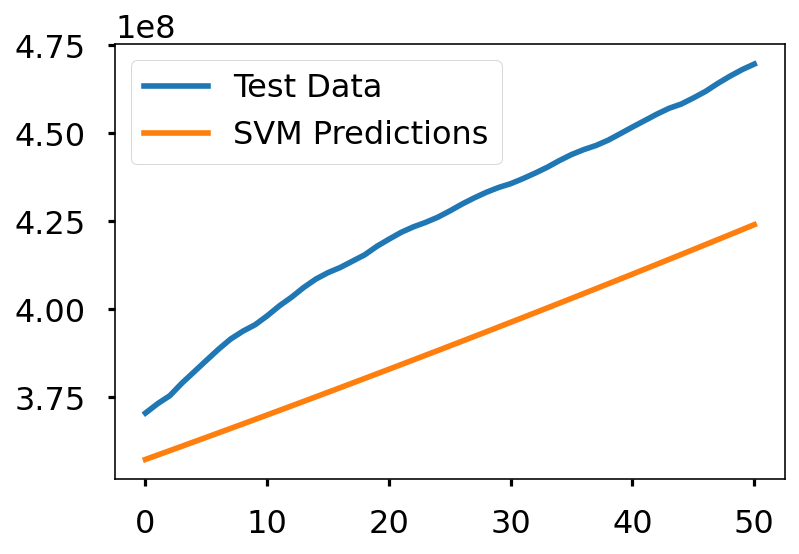

In [12]:
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(y_test_confirmed)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

# Polynomial Regression

In [13]:
# transform our data for polynomial regression
poly = PolynomialFeatures(degree=2)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)


In [14]:
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 92497247.51088765
MSE: 8856720168644269.0


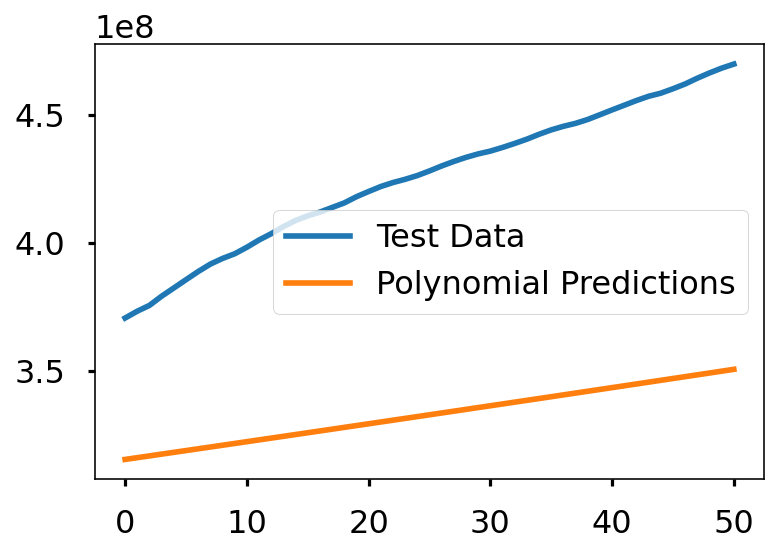

In [15]:
plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)
plt.legend(['Test Data', 'Polynomial Predictions'])

# Worldwide visualization


In [16]:
# helper method for flattening the data, so it can be displayed on a bar graph 
def flatten(arr):
    a = [] 
    arr = arr.tolist()
    for i in arr:
        a.append(i[0])
    return a

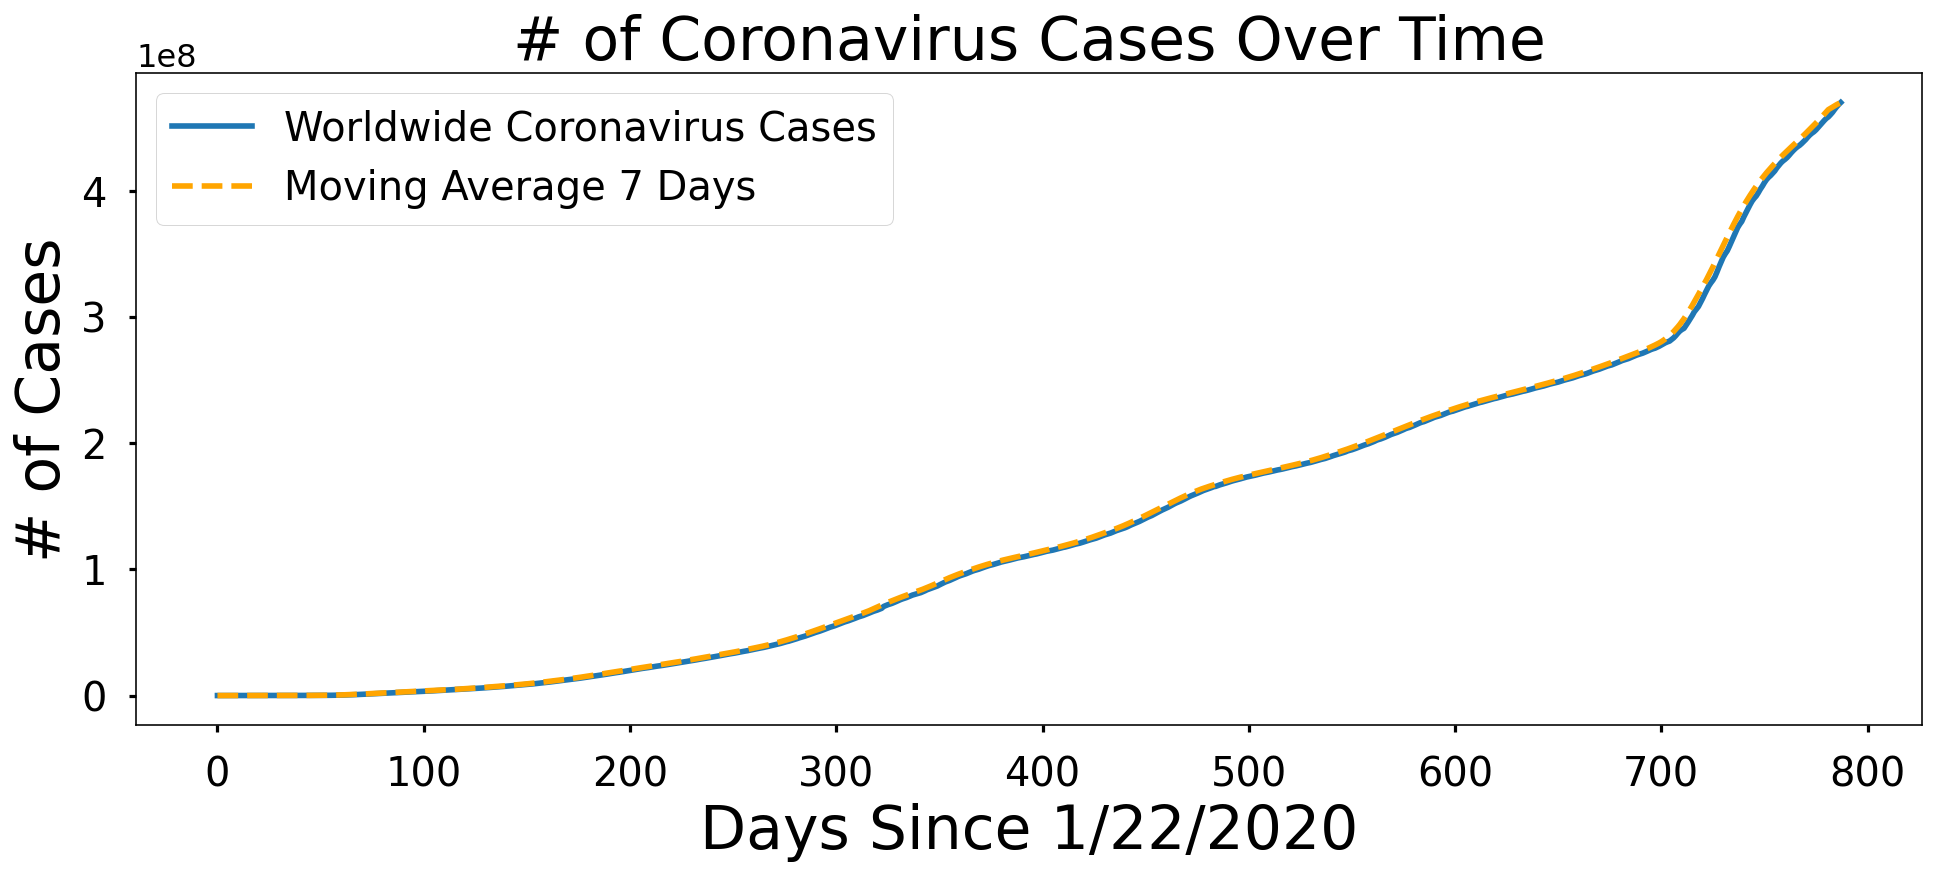

In [17]:
adjusted_dates = adjusted_dates.reshape(1, -1)[0]
plt.figure(figsize=(16, 6))
plt.plot(adjusted_dates, world_cases)
plt.plot(adjusted_dates, world_confirmed_avg, linestyle='dashed', color='orange')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Worldwide Coronavirus Cases', 'Moving Average {} Days'.format(window)], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


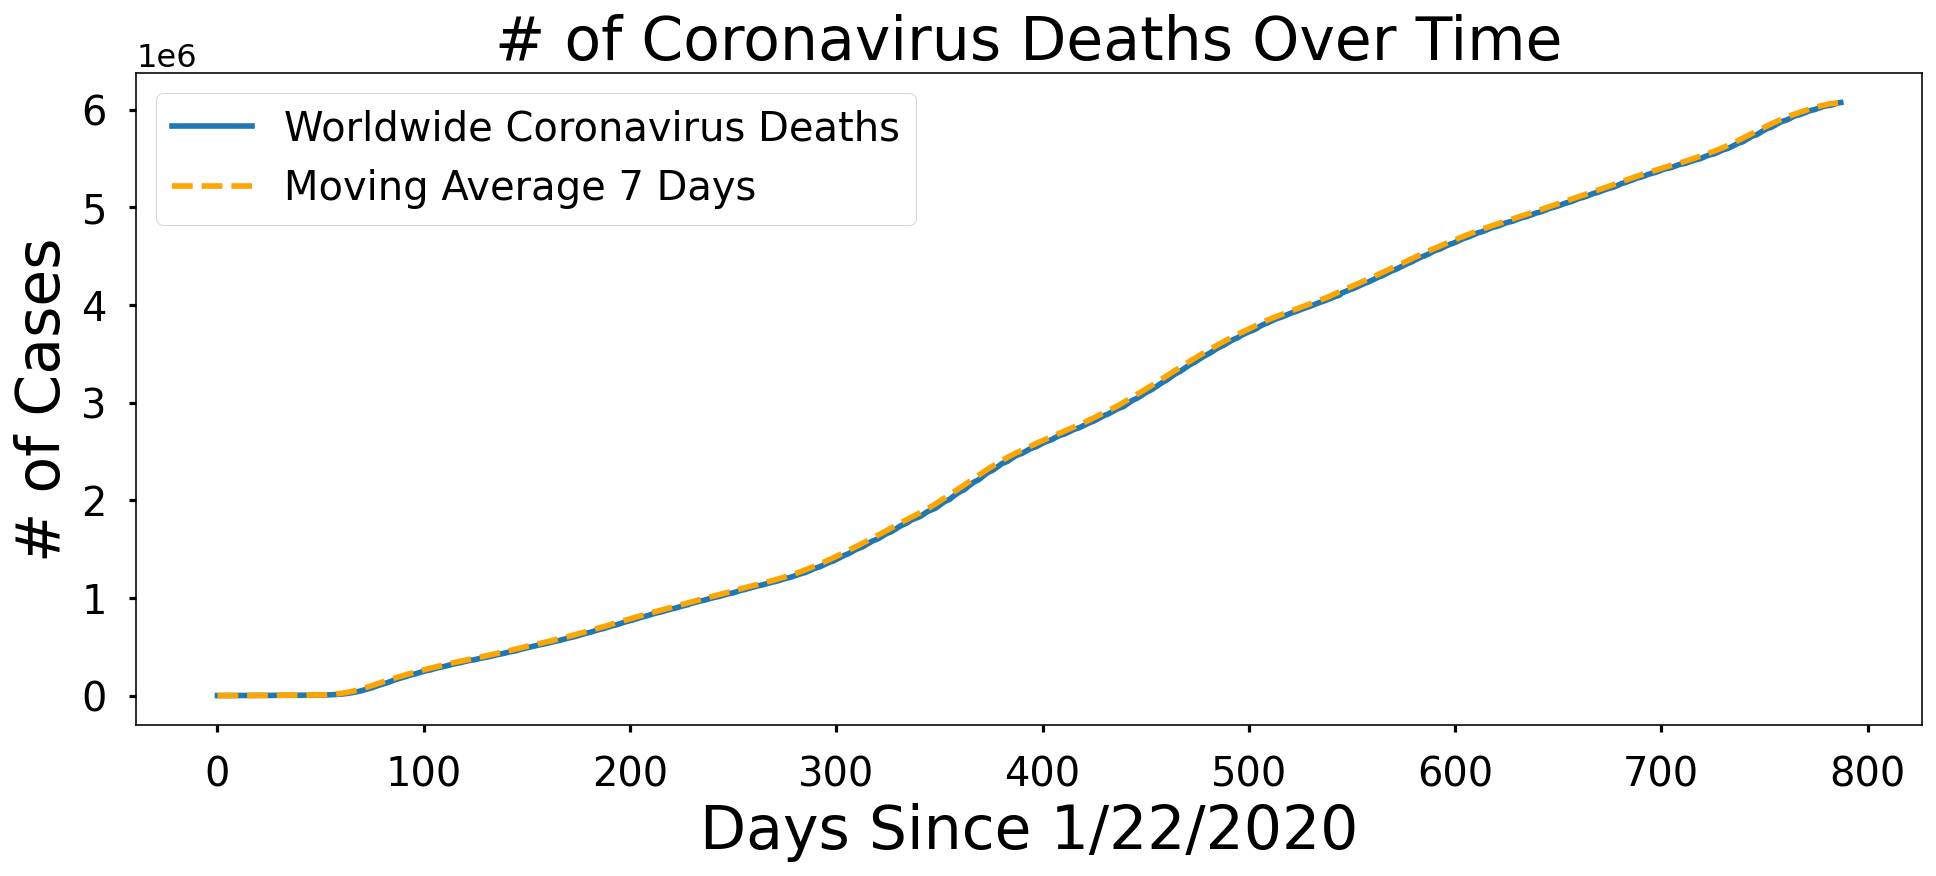

In [19]:
plt.figure(figsize=(16, 6))
plt.plot(adjusted_dates, total_deaths)
plt.plot(adjusted_dates, world_death_avg, linestyle='dashed', color='orange')
plt.title('# of Coronavirus Deaths Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Worldwide Coronavirus Deaths', 'Moving Average {} Days'.format(window)], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()


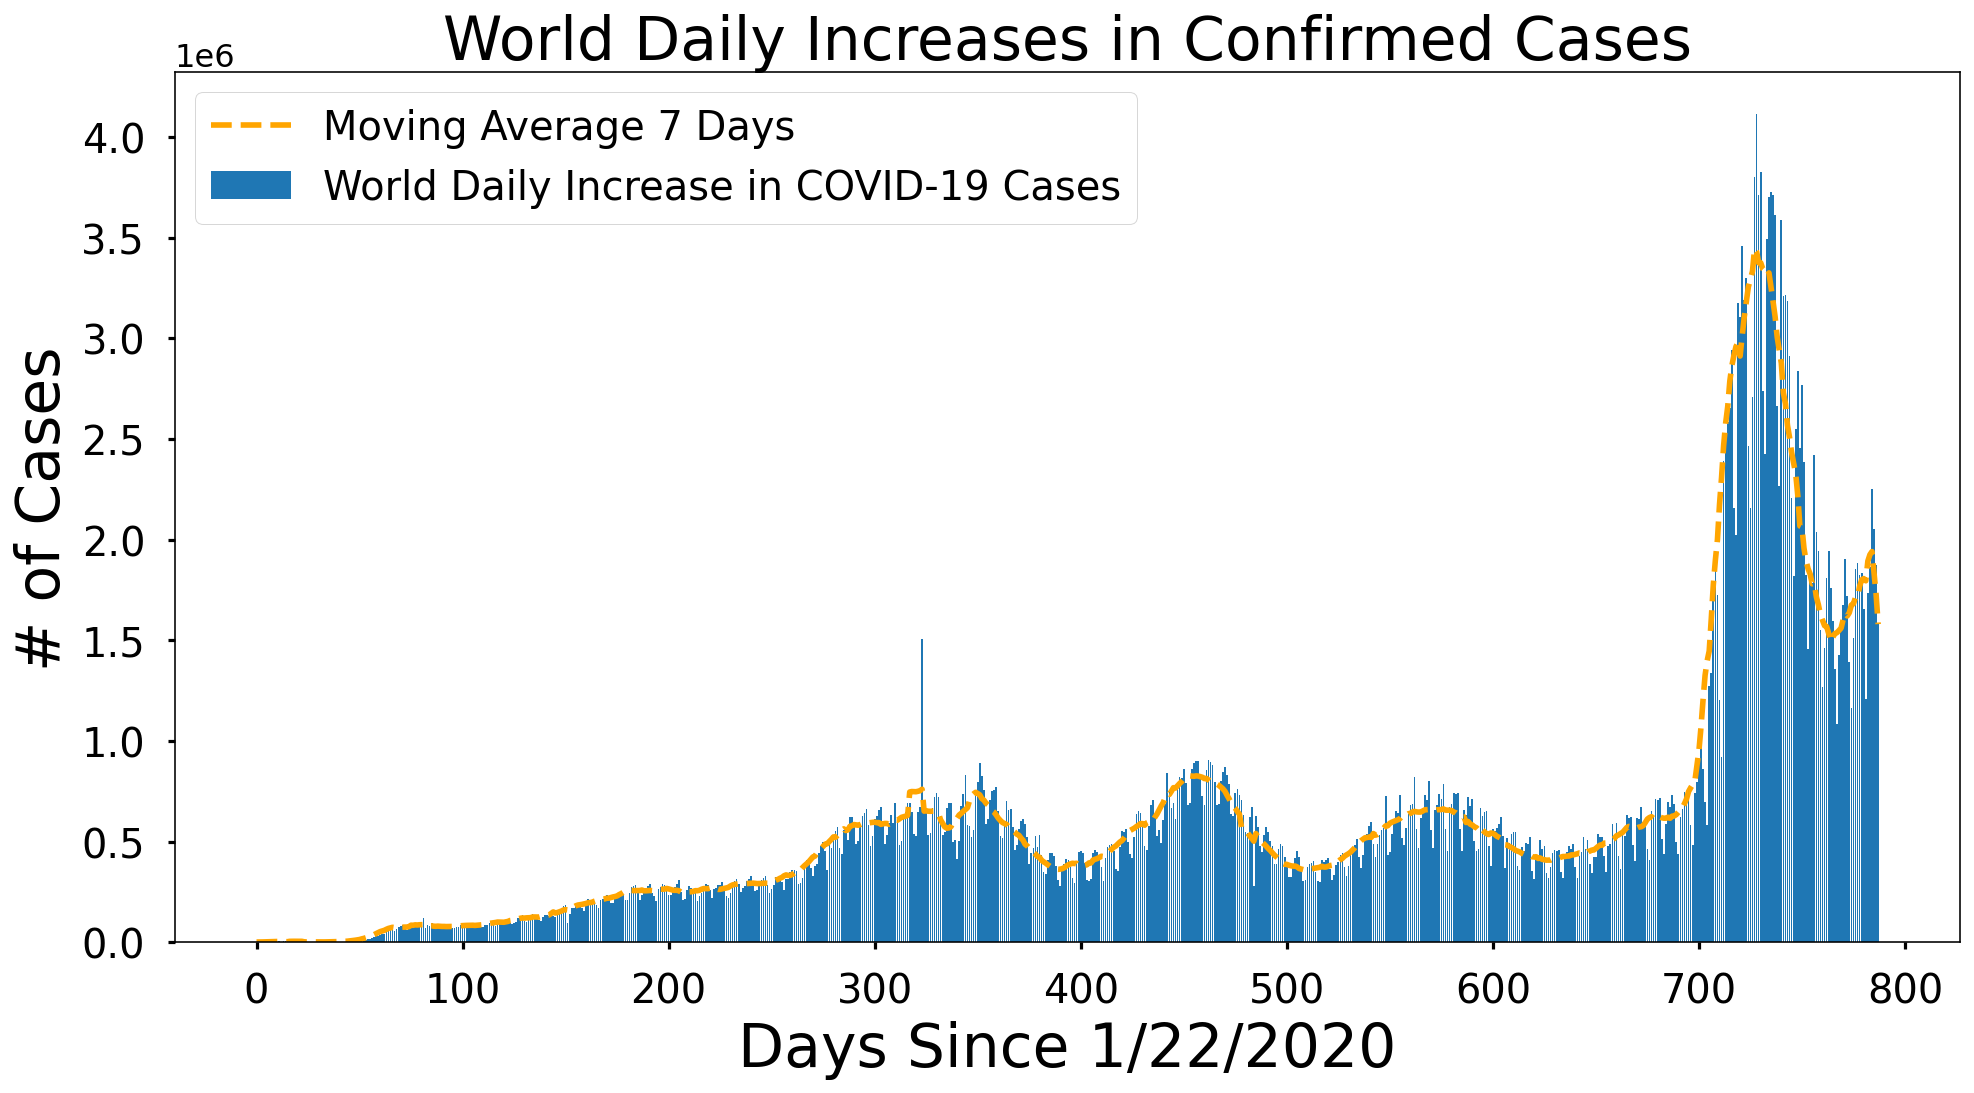

In [20]:
plt.figure(figsize=(16, 8))
plt.bar(adjusted_dates, world_daily_increase)
plt.plot(adjusted_dates, world_daily_increase_avg, color='orange', linestyle='dashed')
plt.title('World Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Moving Average {} Days'.format(window), 'World Daily Increase in COVID-19 Cases'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

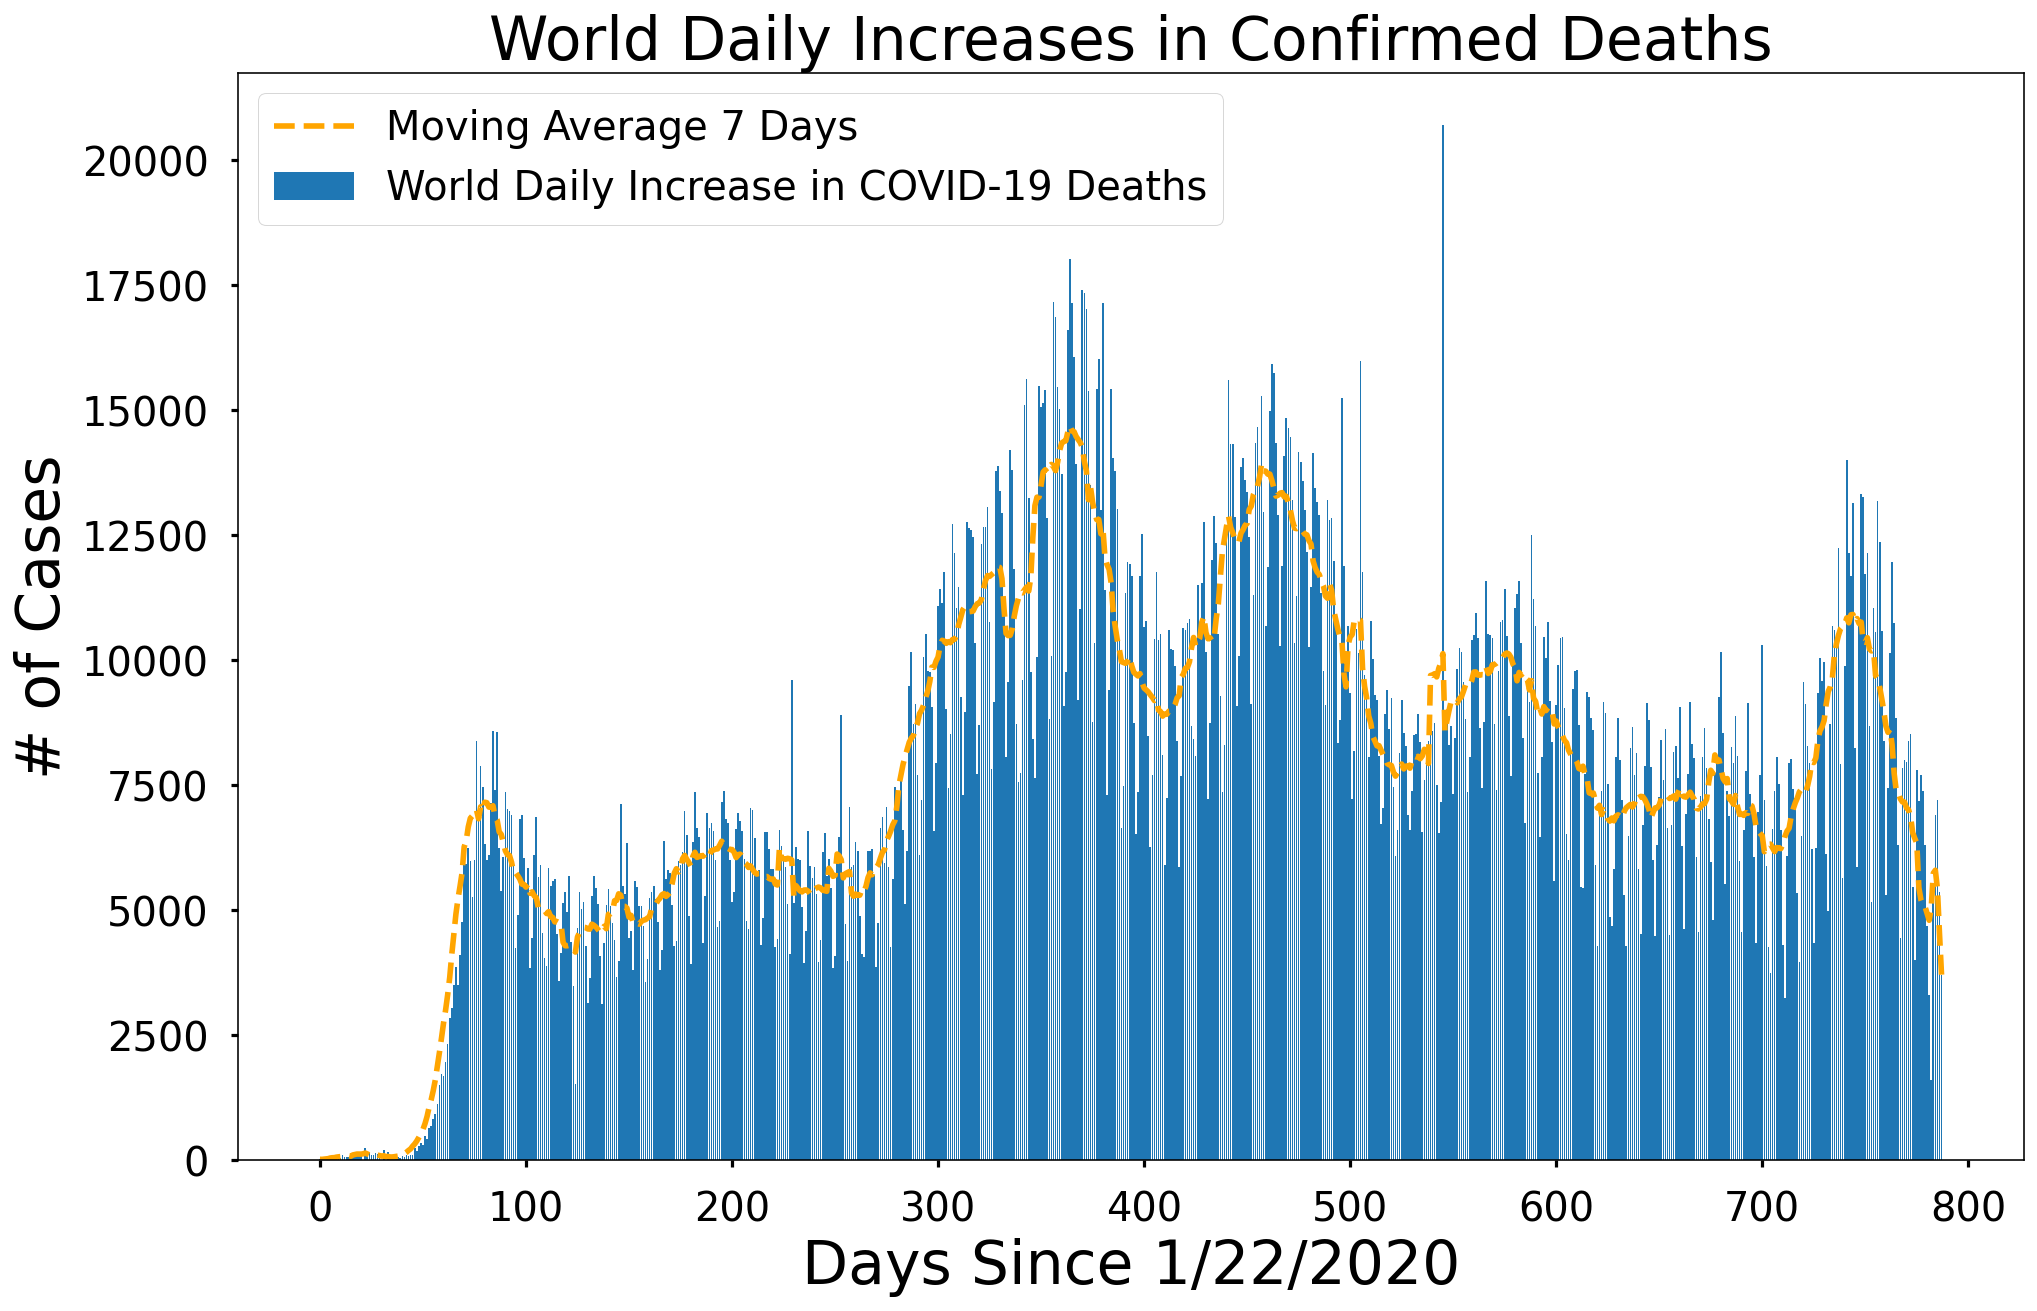

In [21]:
plt.figure(figsize=(16, 10))
plt.bar(adjusted_dates, world_daily_death)
plt.plot(adjusted_dates, world_daily_death_avg, color='orange', linestyle='dashed')
plt.title('World Daily Increases in Confirmed Deaths', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Moving Average {} Days'.format(window), 'World Daily Increase in COVID-19 Deaths'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()


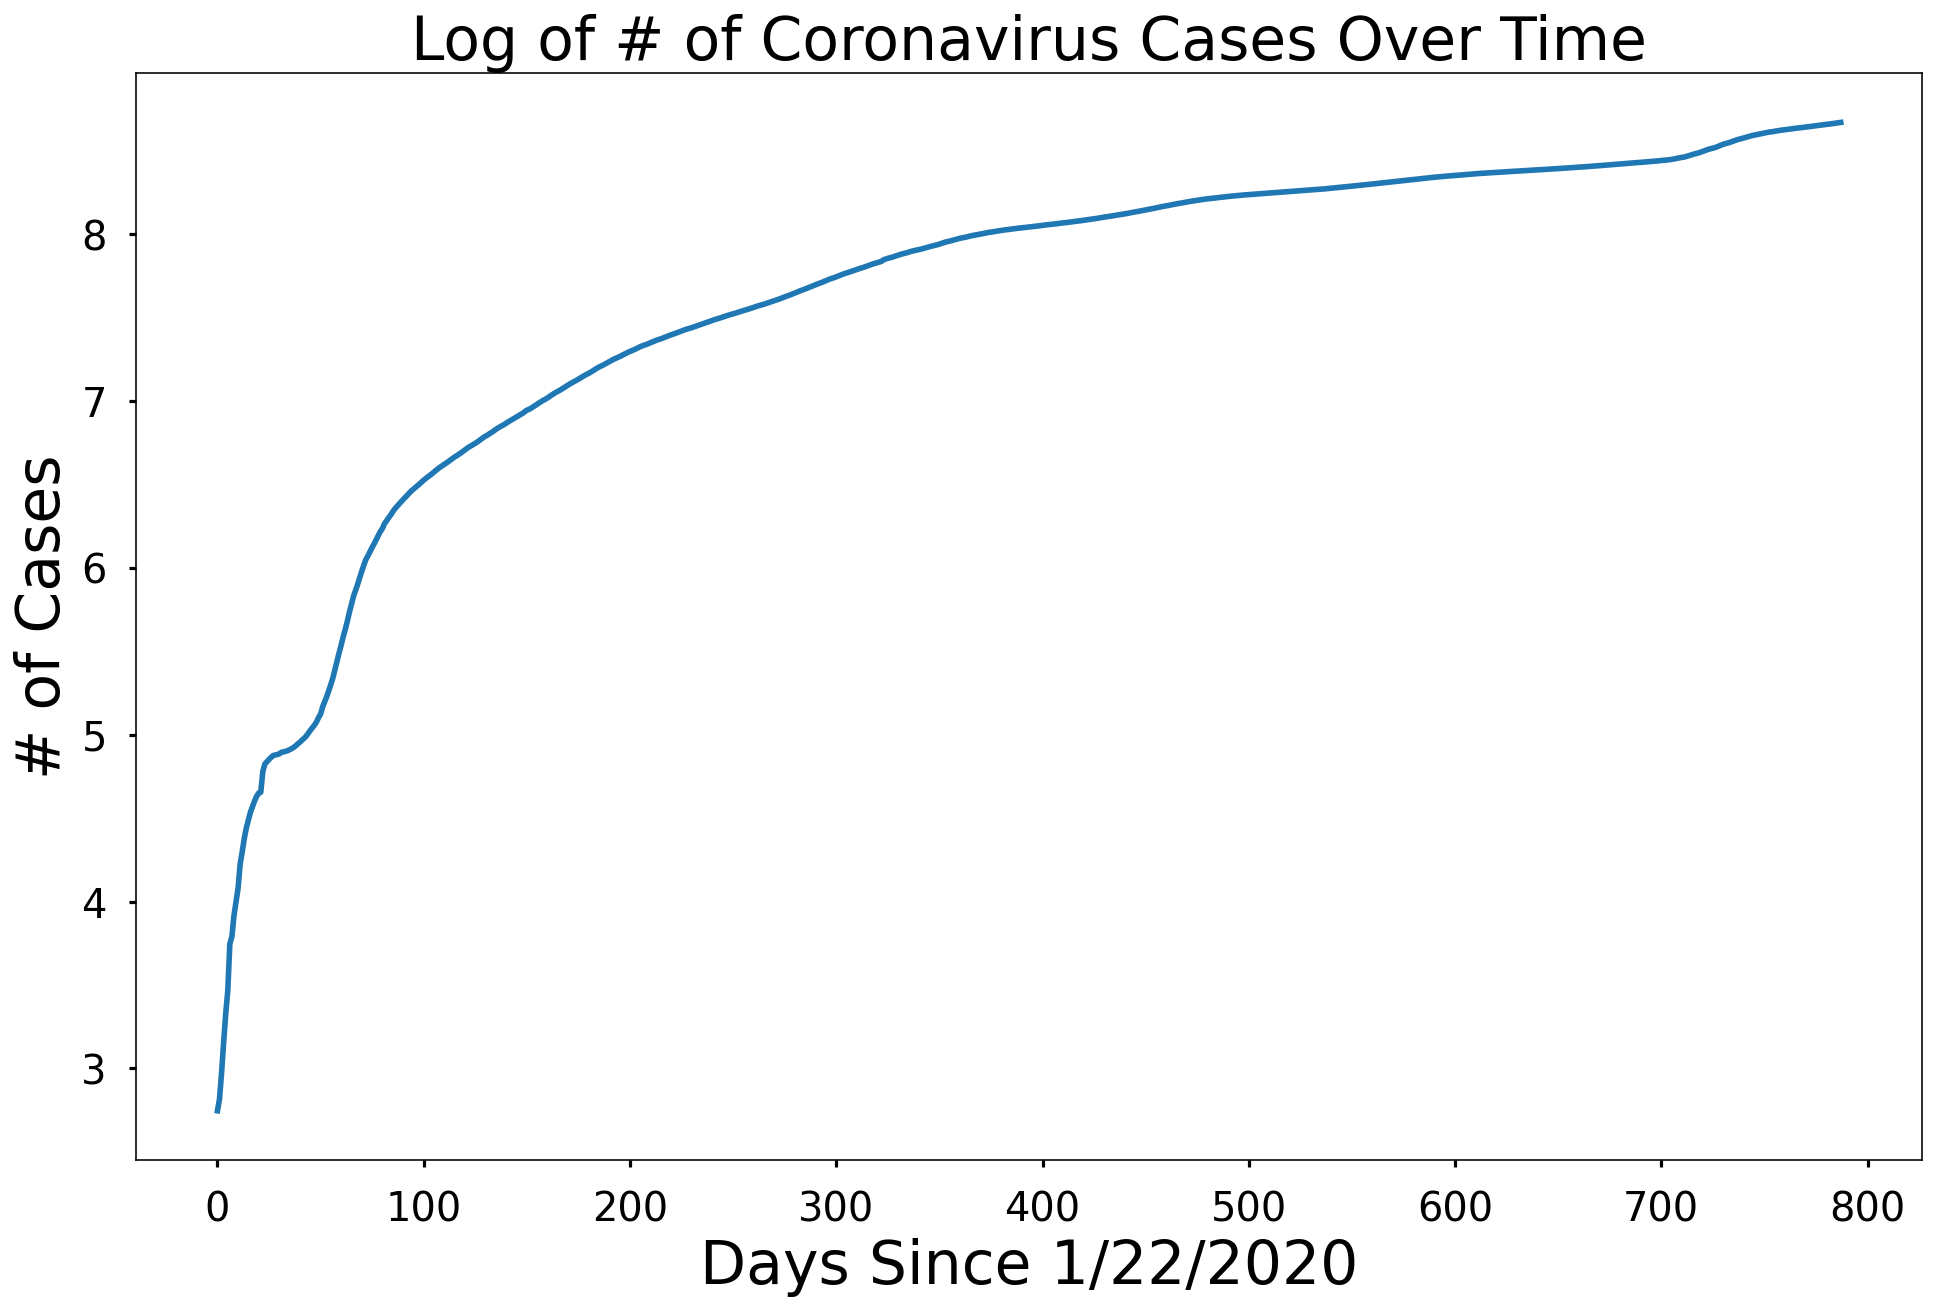

In [22]:
plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, np.log10(world_cases))
plt.title('Log of # of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()


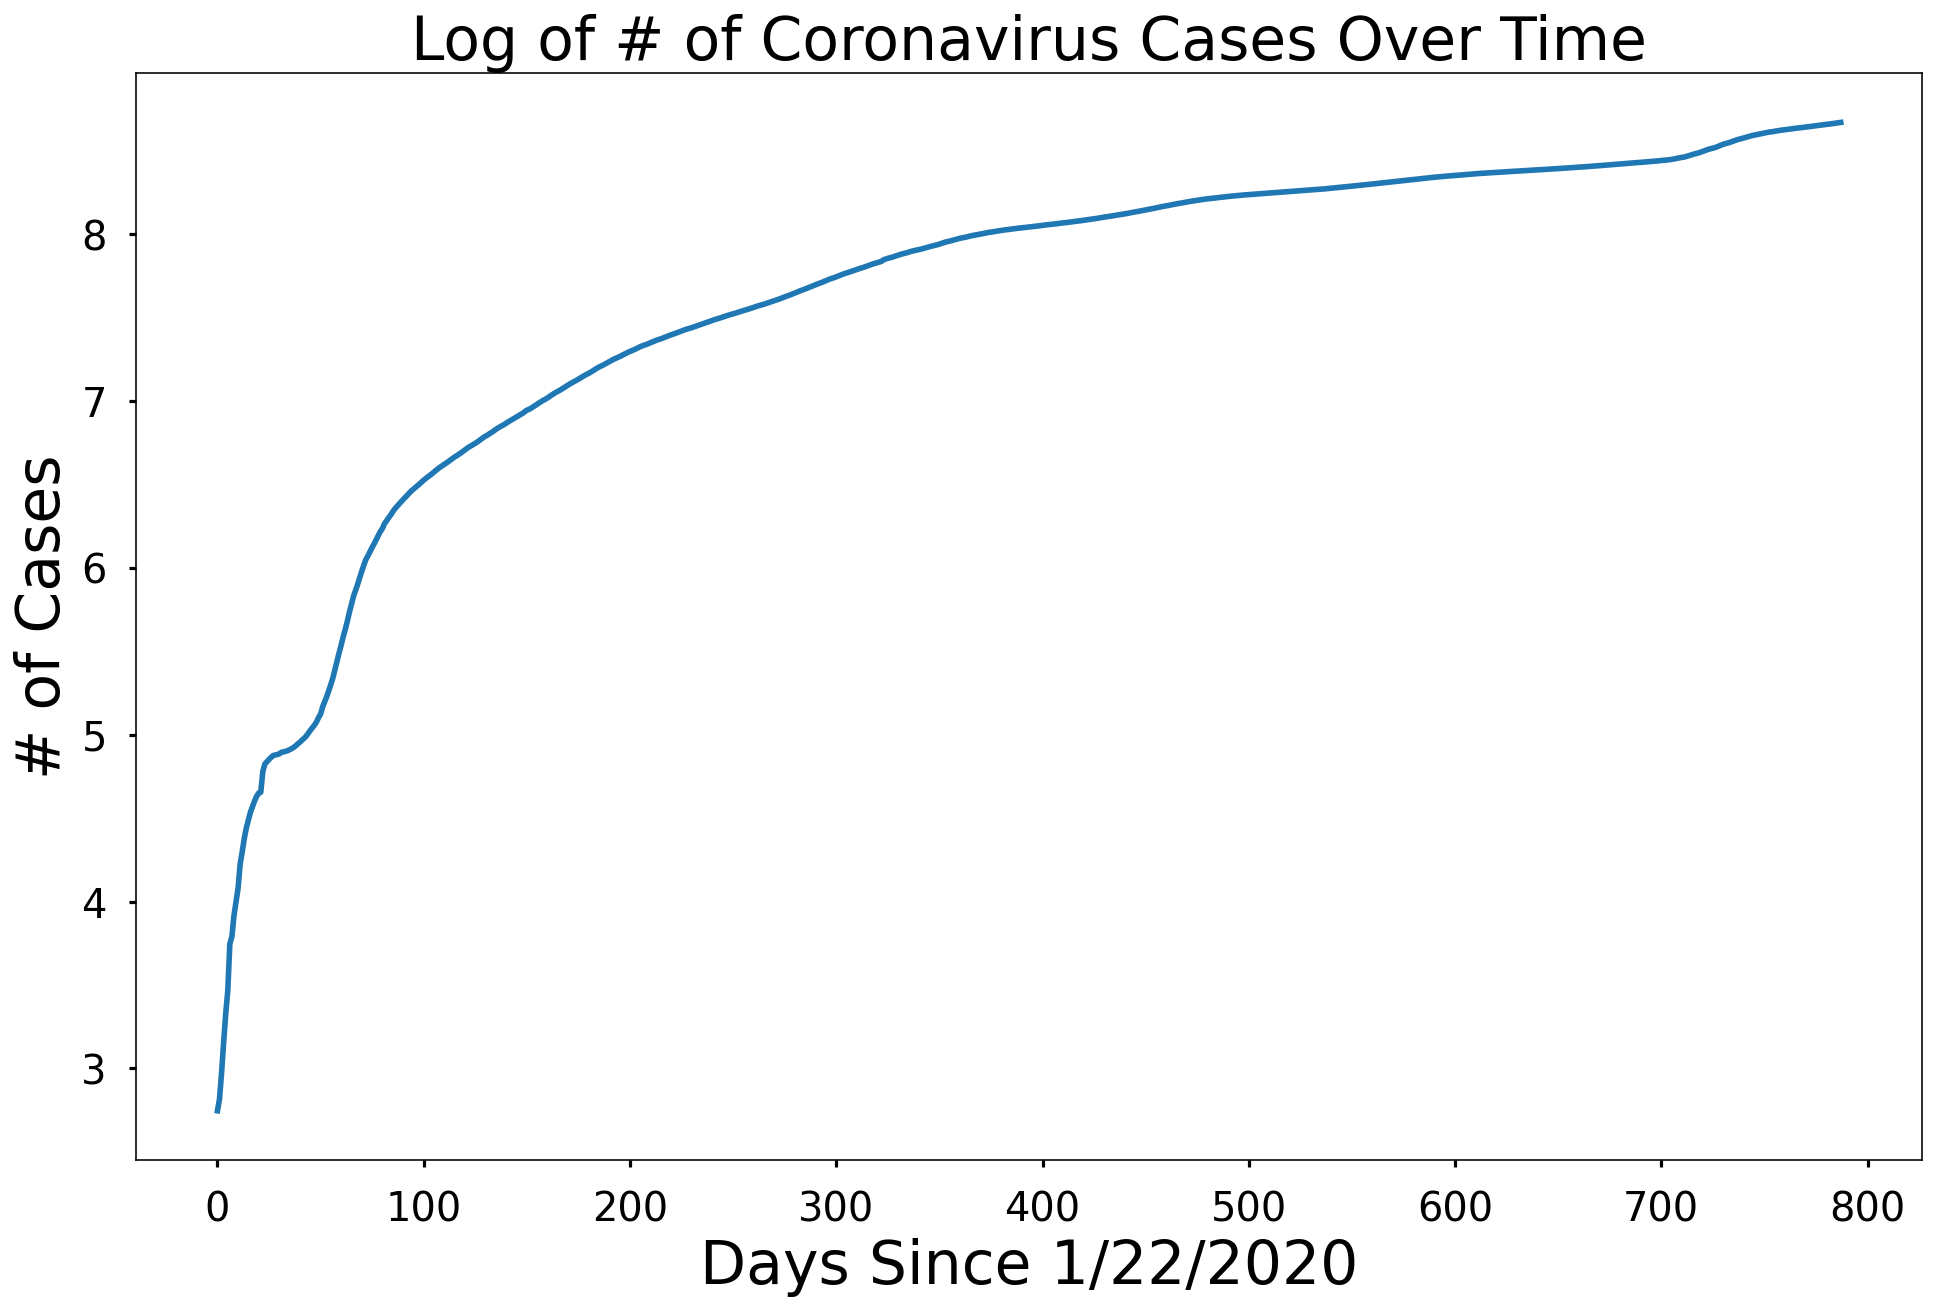

In [23]:
plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, np.log10(world_cases))
plt.title('Log of # of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()


In [24]:
def country_plot(x, y1, y2, y3, country):
    # window is set as 7 in in the beginning of the notebook 
    confirmed_avg = moving_average(y1, window)
    confirmed_increase_avg = moving_average(y2, window)
    death_increase_avg = moving_average(y3, window)
    
    plt.figure(figsize=(16, 10))
    plt.plot(x, y1)
    plt.plot(x, confirmed_avg, color='red', linestyle='dashed')
    plt.legend(['{} Confirmed Cases'.format(country), 'Moving Average {} Days'.format(window)], prop={'size': 20})
    plt.title('{} Confirmed Cases'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

    plt.figure(figsize=(16, 10))
    plt.bar(x, y2)
    plt.plot(x, confirmed_increase_avg, color='red', linestyle='dashed')
    plt.legend(['Moving Average {} Days'.format(window), '{} Daily Increase in Confirmed Cases'.format(country)], prop={'size': 20})
    plt.title('{} Daily Increases in Confirmed Cases'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

    plt.figure(figsize=(16, 10))
    plt.bar(x, y3)
    plt.plot(x, death_increase_avg, color='red', linestyle='dashed')
    plt.legend(['Moving Average {} Days'.format(window), '{} Daily Increase in Confirmed Deaths'.format(country)], prop={'size': 20})
    plt.title('{} Daily Increases in Deaths'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()


# helper function for getting country's cases, deaths       
def get_country_info(country_name):
    country_cases = []
    country_deaths = []
    
    for i in dates:
        country_cases.append(confirmed_df[confirmed_df['Country/Region']==country_name][i].sum())
        country_deaths.append(deaths_df[deaths_df['Country/Region']==country_name][i].sum())
    return (country_cases, country_deaths)
    
    
def country_visualizations(country_name):
    country_info = get_country_info(country_name)
    country_cases = country_info[0]
    country_deaths = country_info[1]
    
    country_daily_increase = daily_increase(country_cases)
    country_daily_death = daily_increase(country_deaths)
    
    country_plot(adjusted_dates, country_cases, country_daily_increase, country_daily_death, country_name)
    

In [25]:
countries = ['US', 'Russia', 'India', 'Brazil', 'South Africa', 'China', 'Italy',
             'Germany', 'Spain', 'France', 'United Kingdom', 'Peru', 'Mexico', 'Colombia', 'Argentina', 'Saudi Arabia', 'Iran', 'Bangladesh',
            'Pakistan', 'Turkey', 'Philippines', 'Iraq', 'Indonesia', 'Israel', 'Ukraine', 'Ecuador', 'Bolivia', 'Netherlands', 'Belgium', 'Poland', 'Czechia', 'Switzerland',
            'Romania', 'Morocco','Portugal', 'Austria', 'Sweden'] 

for country in countries:
    country_visualizations(country)

Output hidden; open in https://colab.research.google.com to view.

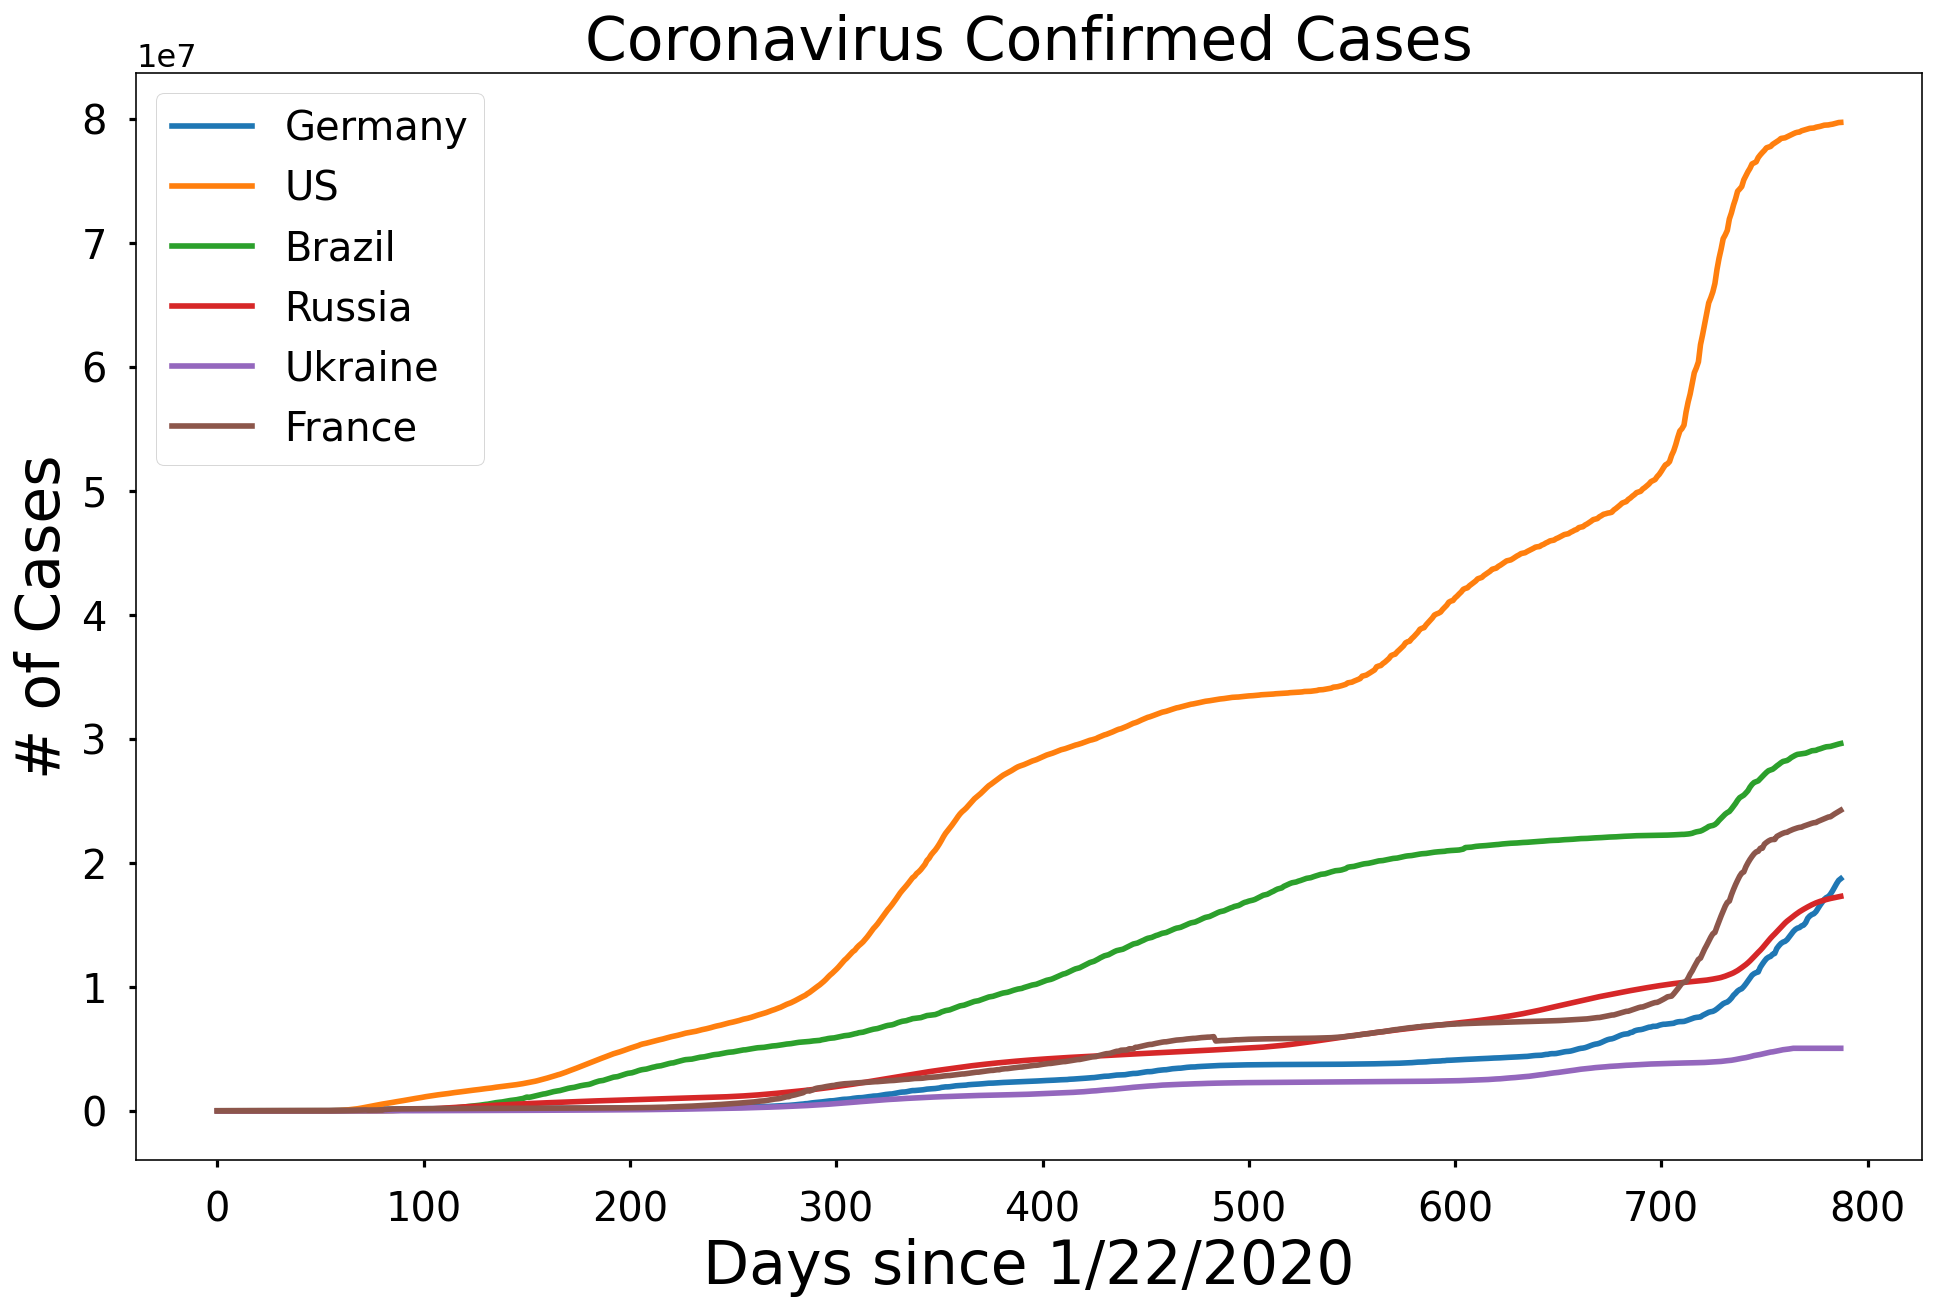

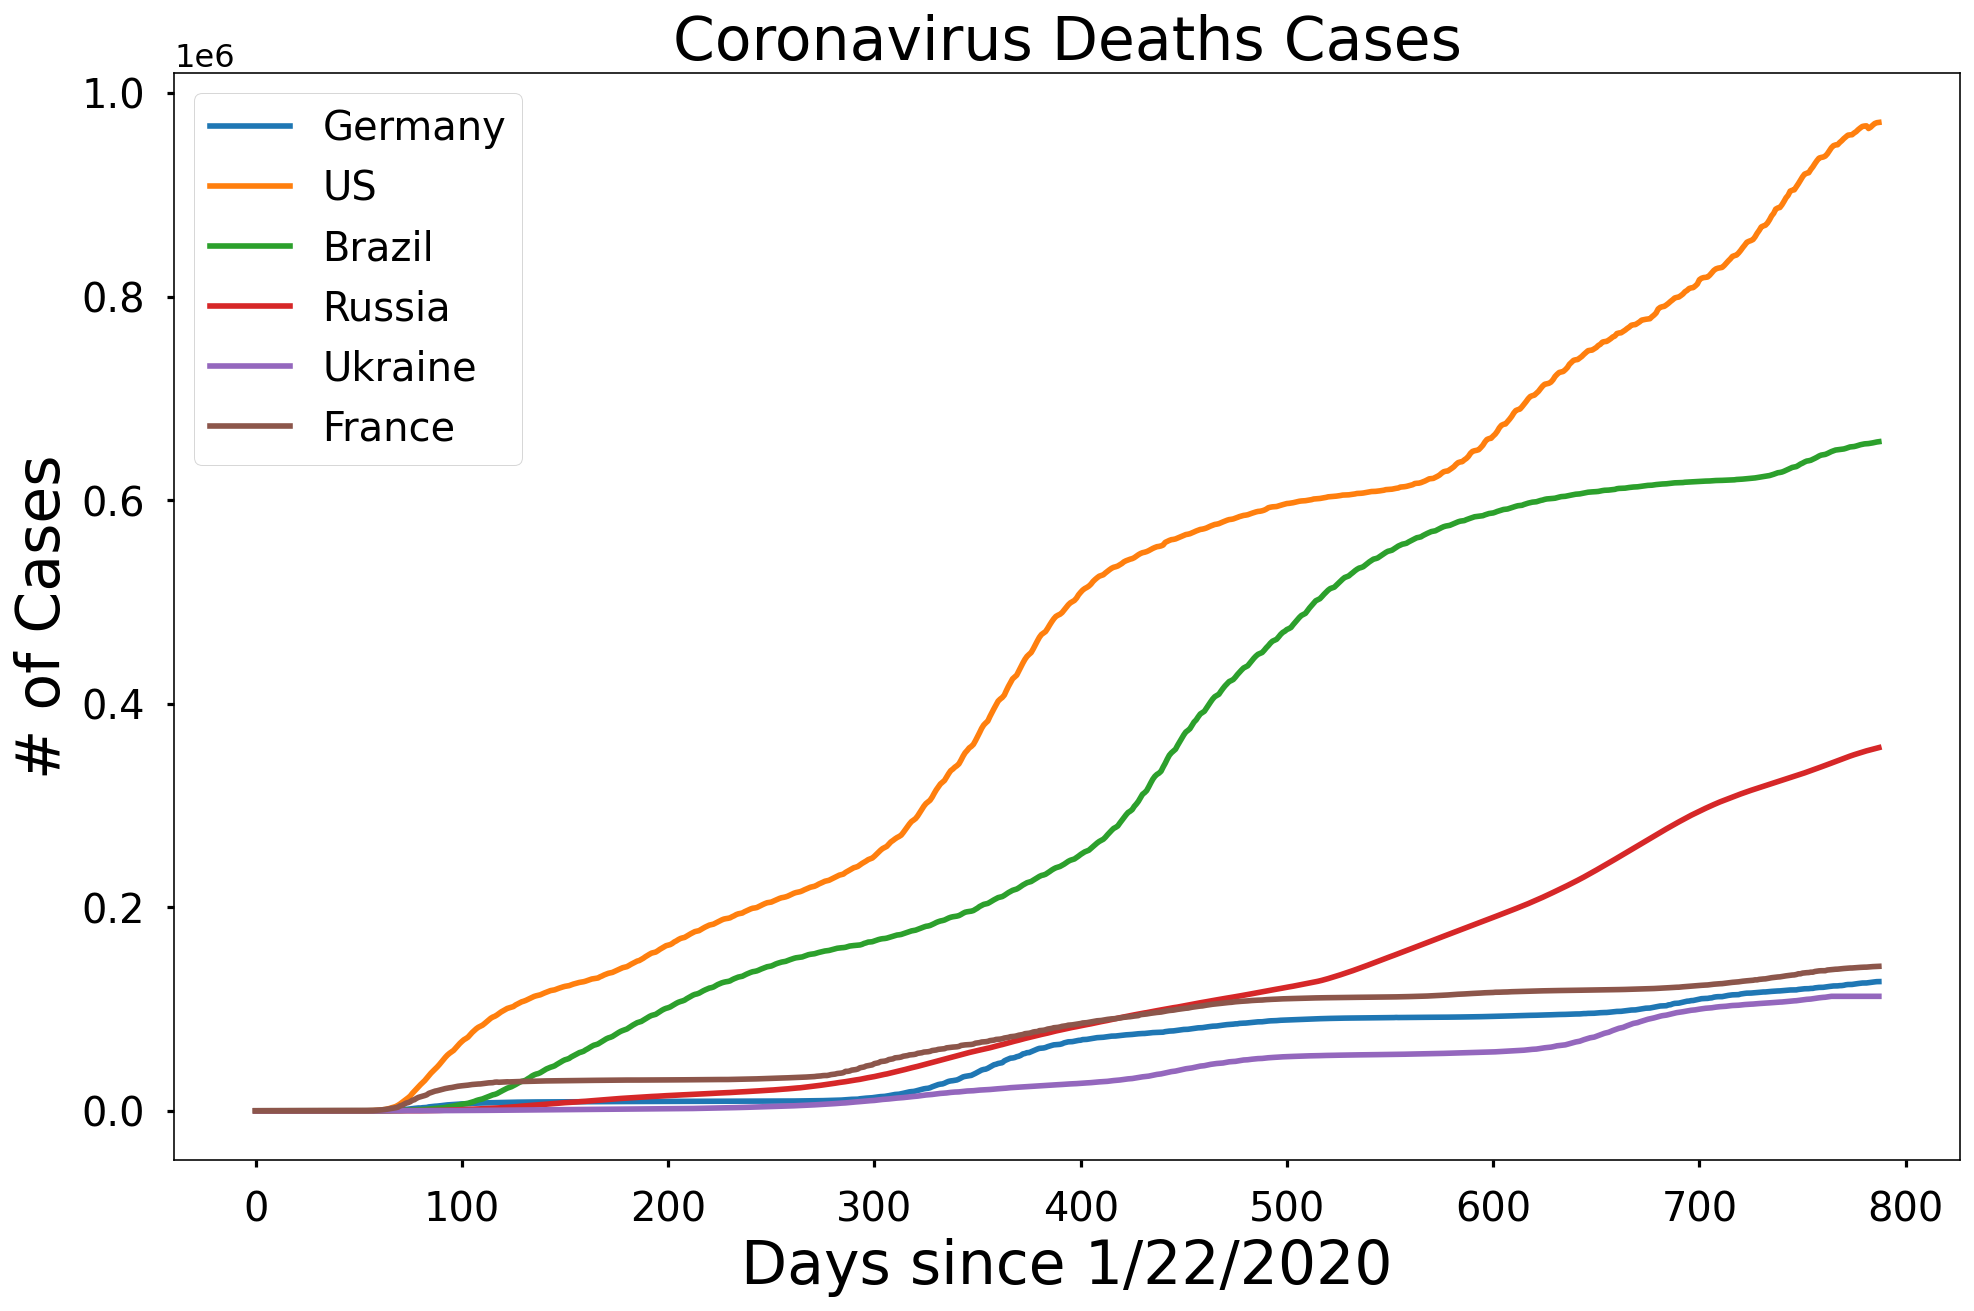

In [26]:
compare_countries = ['Germany', 'US', 'Brazil', 'Russia', 'Ukraine', 'France'] 
graph_name = ['Coronavirus Confirmed Cases', 'Coronavirus Deaths Cases']

for num in range(2):
    plt.figure(figsize=(16, 10))
    for country in compare_countries:
        plt.plot(get_country_info(country)[num])
    plt.legend(compare_countries, prop={'size': 20})
    plt.xlabel('Days since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.title(graph_name[num], size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

In [27]:
def plot_predictions(x, y, pred, algo_name, color):
    plt.figure(figsize=(16, 10))
    plt.plot(x, y)
    plt.plot(future_forcast, pred, linestyle='dashed', color=color)
    plt.title('Worldwide Coronavirus Cases Over Time', size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.legend(['Confirmed Cases', algo_name], prop={'size': 20})
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

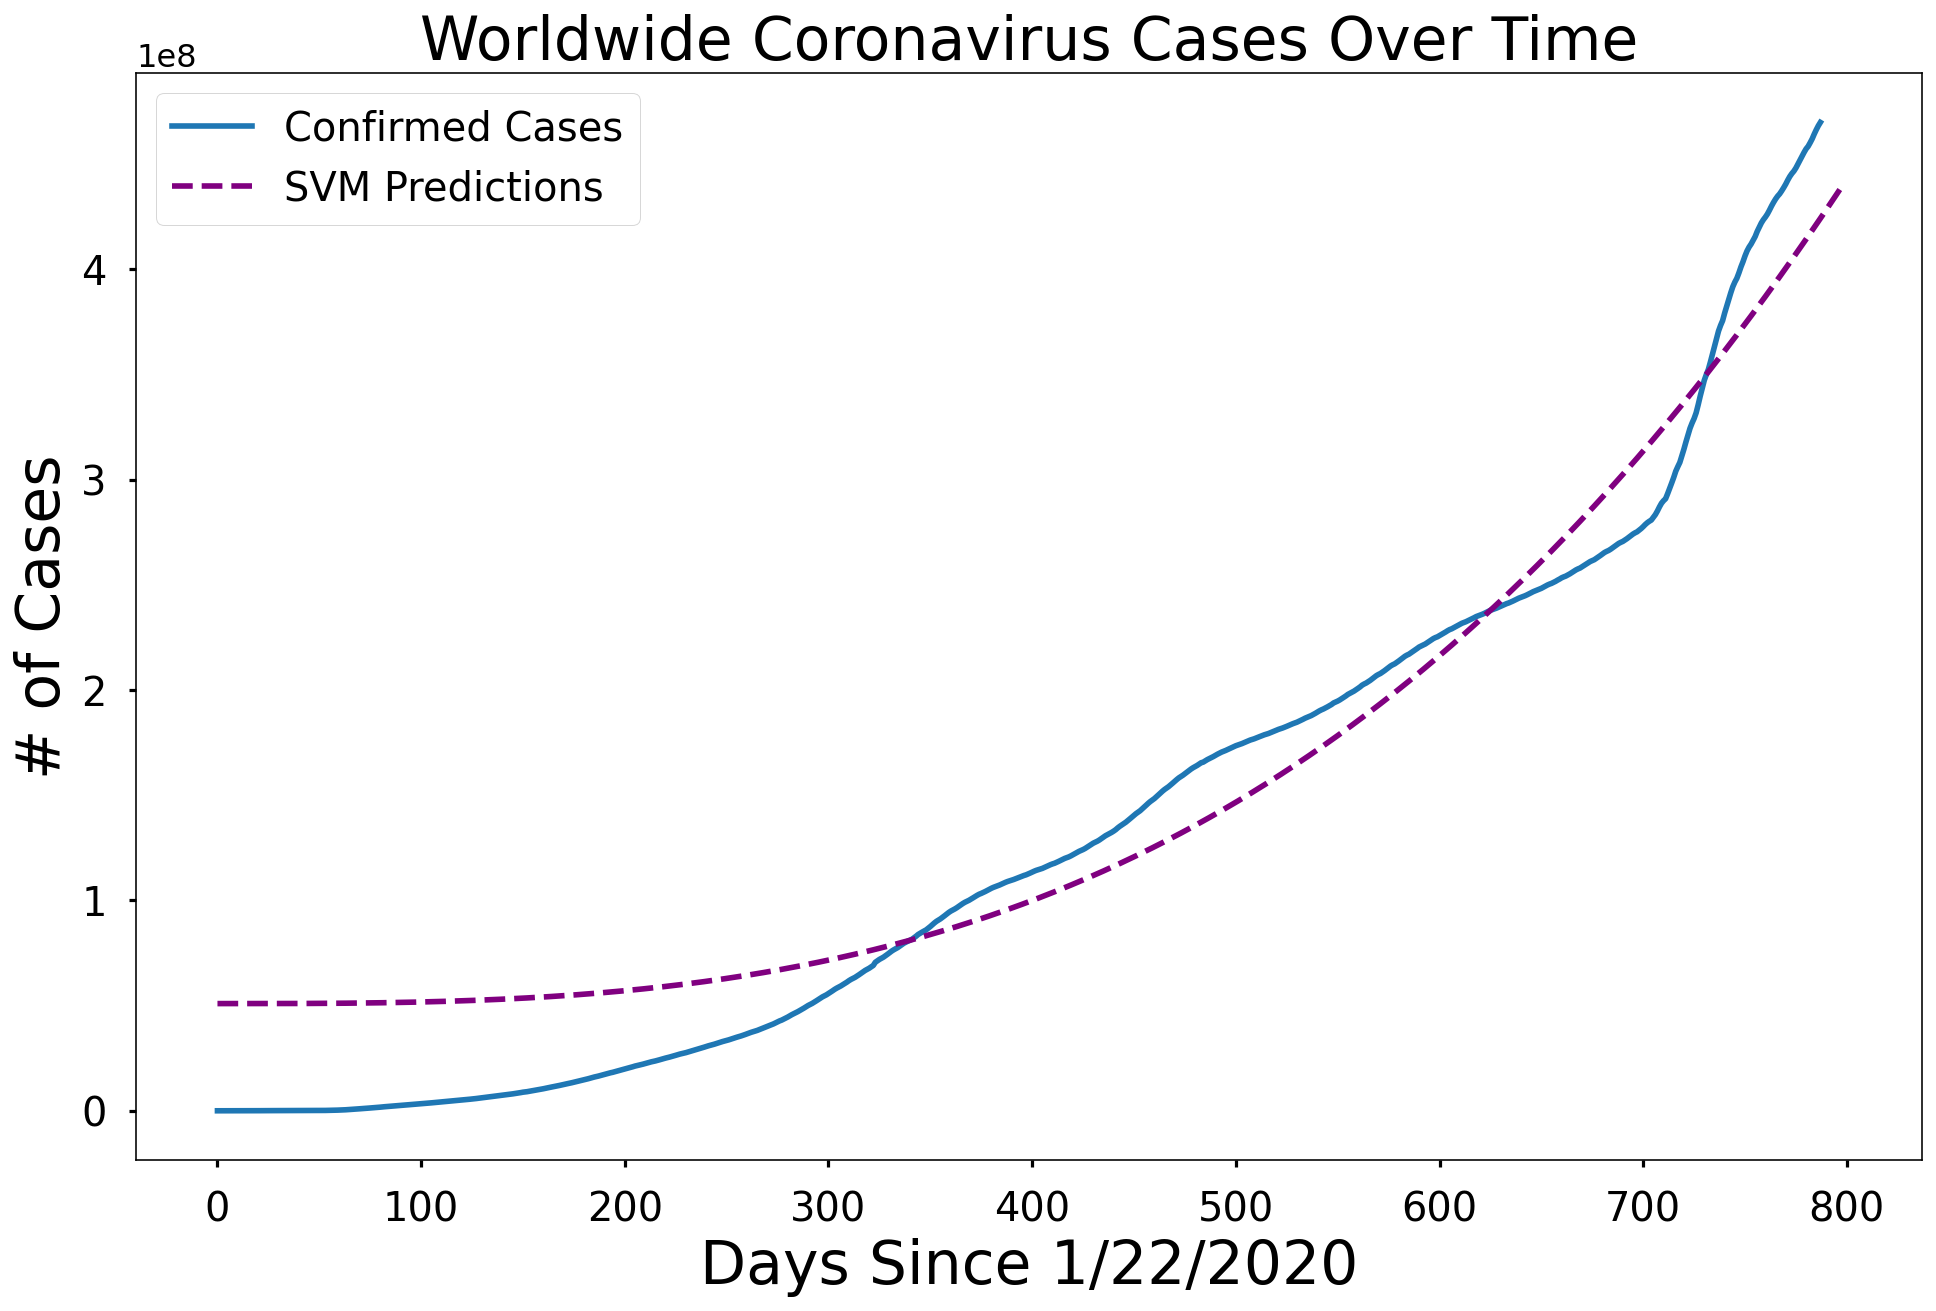

In [28]:
plot_predictions(adjusted_dates, world_cases, svm_pred, 'SVM Predictions', 'purple')


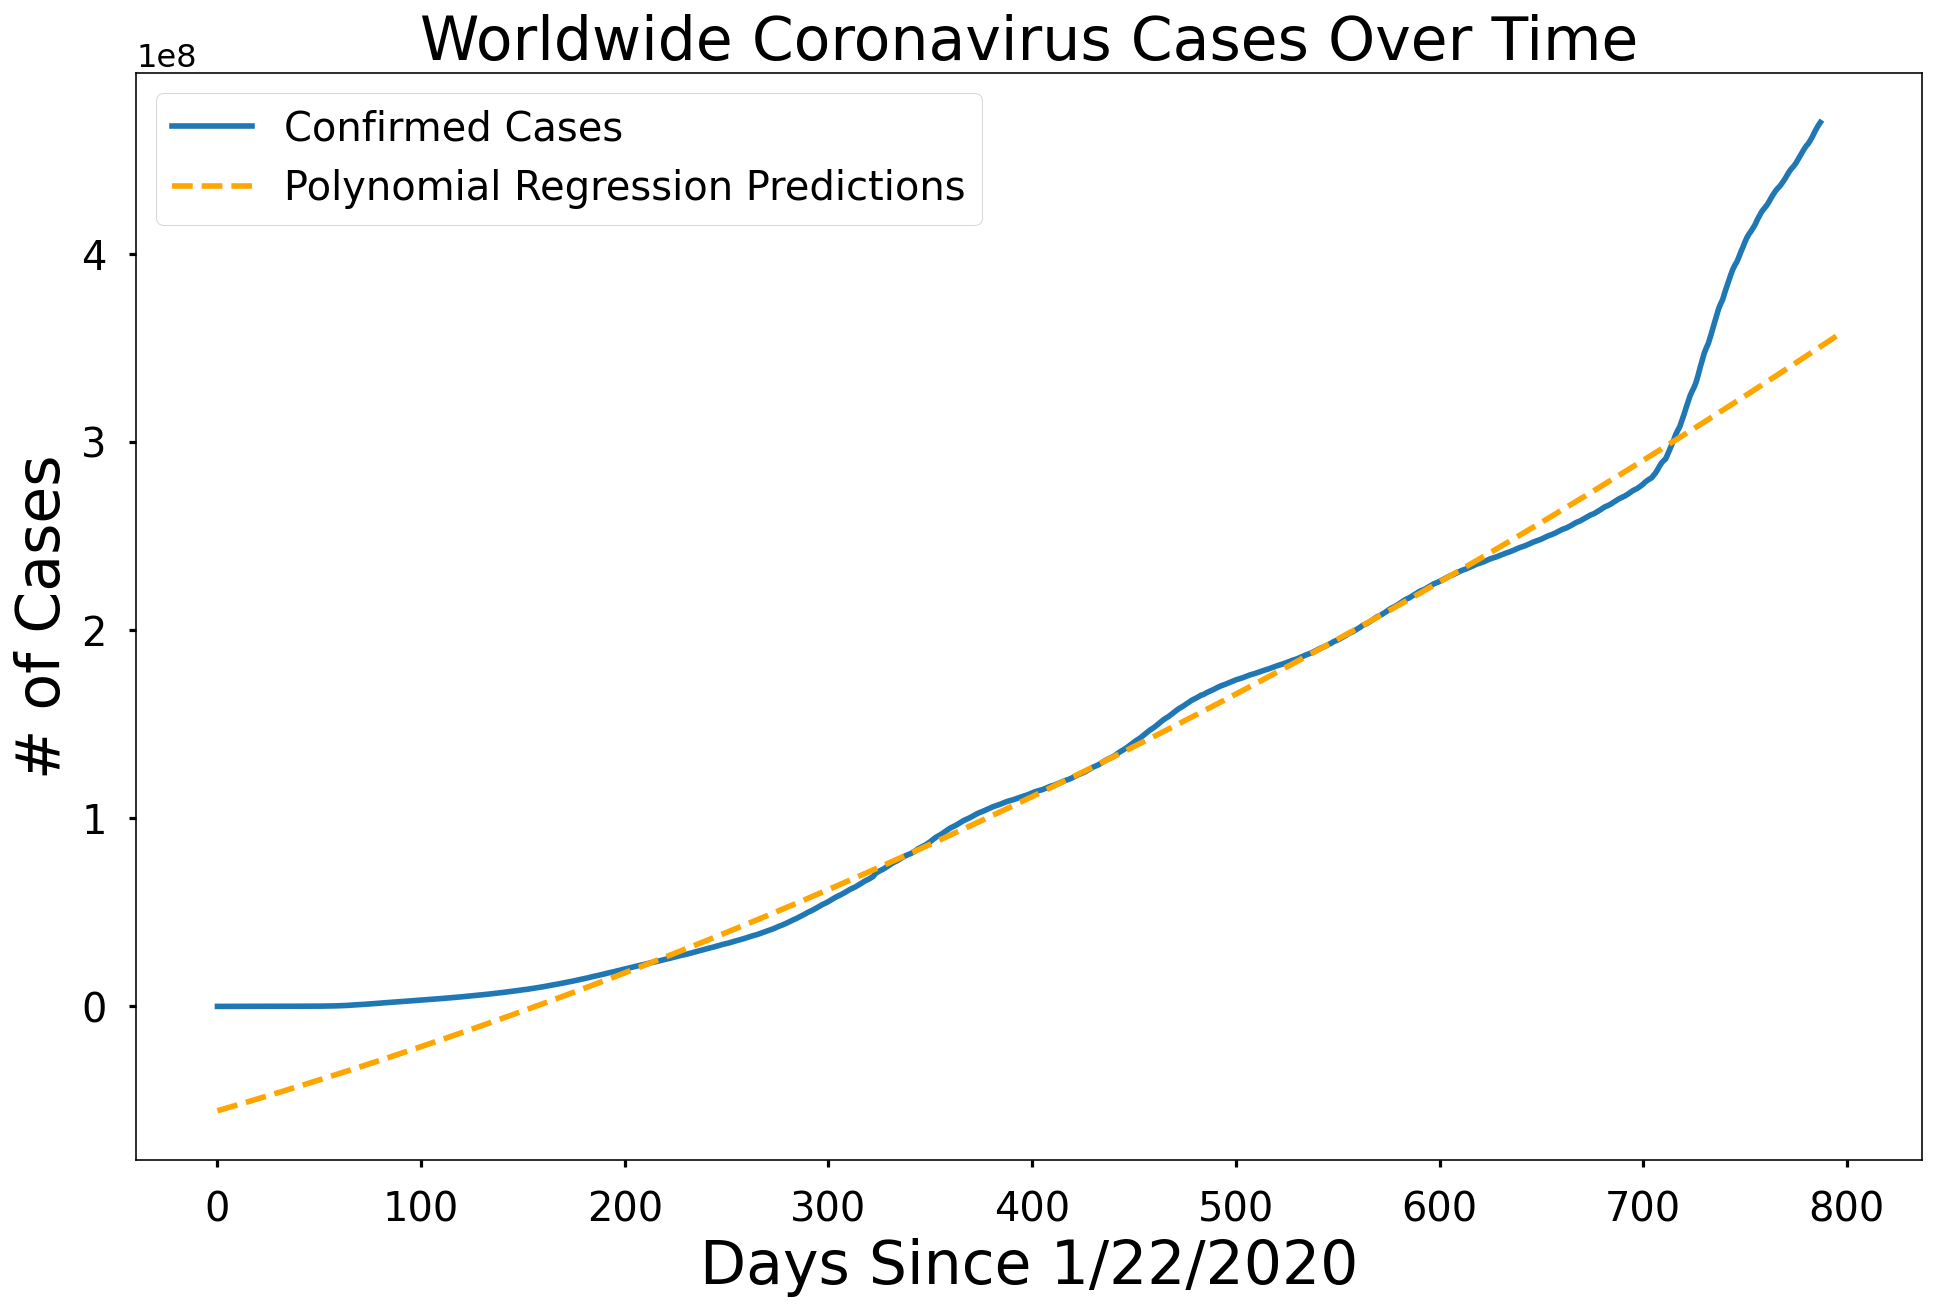

In [29]:
plot_predictions(adjusted_dates, world_cases, linear_pred, 'Polynomial Regression Predictions', 'orange')

In [30]:
# Future predictions using SVM 
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'SVM Predicted # of Confirmed Cases Worldwide': np.round(svm_pred[-10:])})
svm_df.style.background_gradient(cmap='Reds')

,Date,SVM Predicted # of Confirmed Cases Worldwide
0,03/20/2022,425513977.000000
1,03/21/2022,426941824.000000
2,03/22/2022,428373295.000000
3,03/23/2022,429808395.000000
4,03/24/2022,431247128.000000
5,03/25/2022,432689498.000000
6,03/26/2022,434135511.000000
7,03/27/2022,435585171.000000
8,03/28/2022,437038482.000000
9,03/29/2022,438495449.000000


In [31]:
# Future predictions using polynomial regression
linear_pred = linear_pred.reshape(1,-1)[0]
linear_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Polynomial Predicted # of Confirmed Cases Worldwide': np.round(linear_pred[-10:])})
linear_df.style.background_gradient(cmap='Blues')

,Date,Polynomial Predicted # of Confirmed Cases Worldwide
0,03/20/2022,351249530.000000
1,03/21/2022,351966535.000000
2,03/22/2022,352684051.000000
3,03/23/2022,353402075.000000
4,03/24/2022,354120608.000000
5,03/25/2022,354839651.000000
6,03/26/2022,355559203.000000
7,03/27/2022,356279264.000000
8,03/28/2022,356999834.000000
9,03/29/2022,357720914.000000


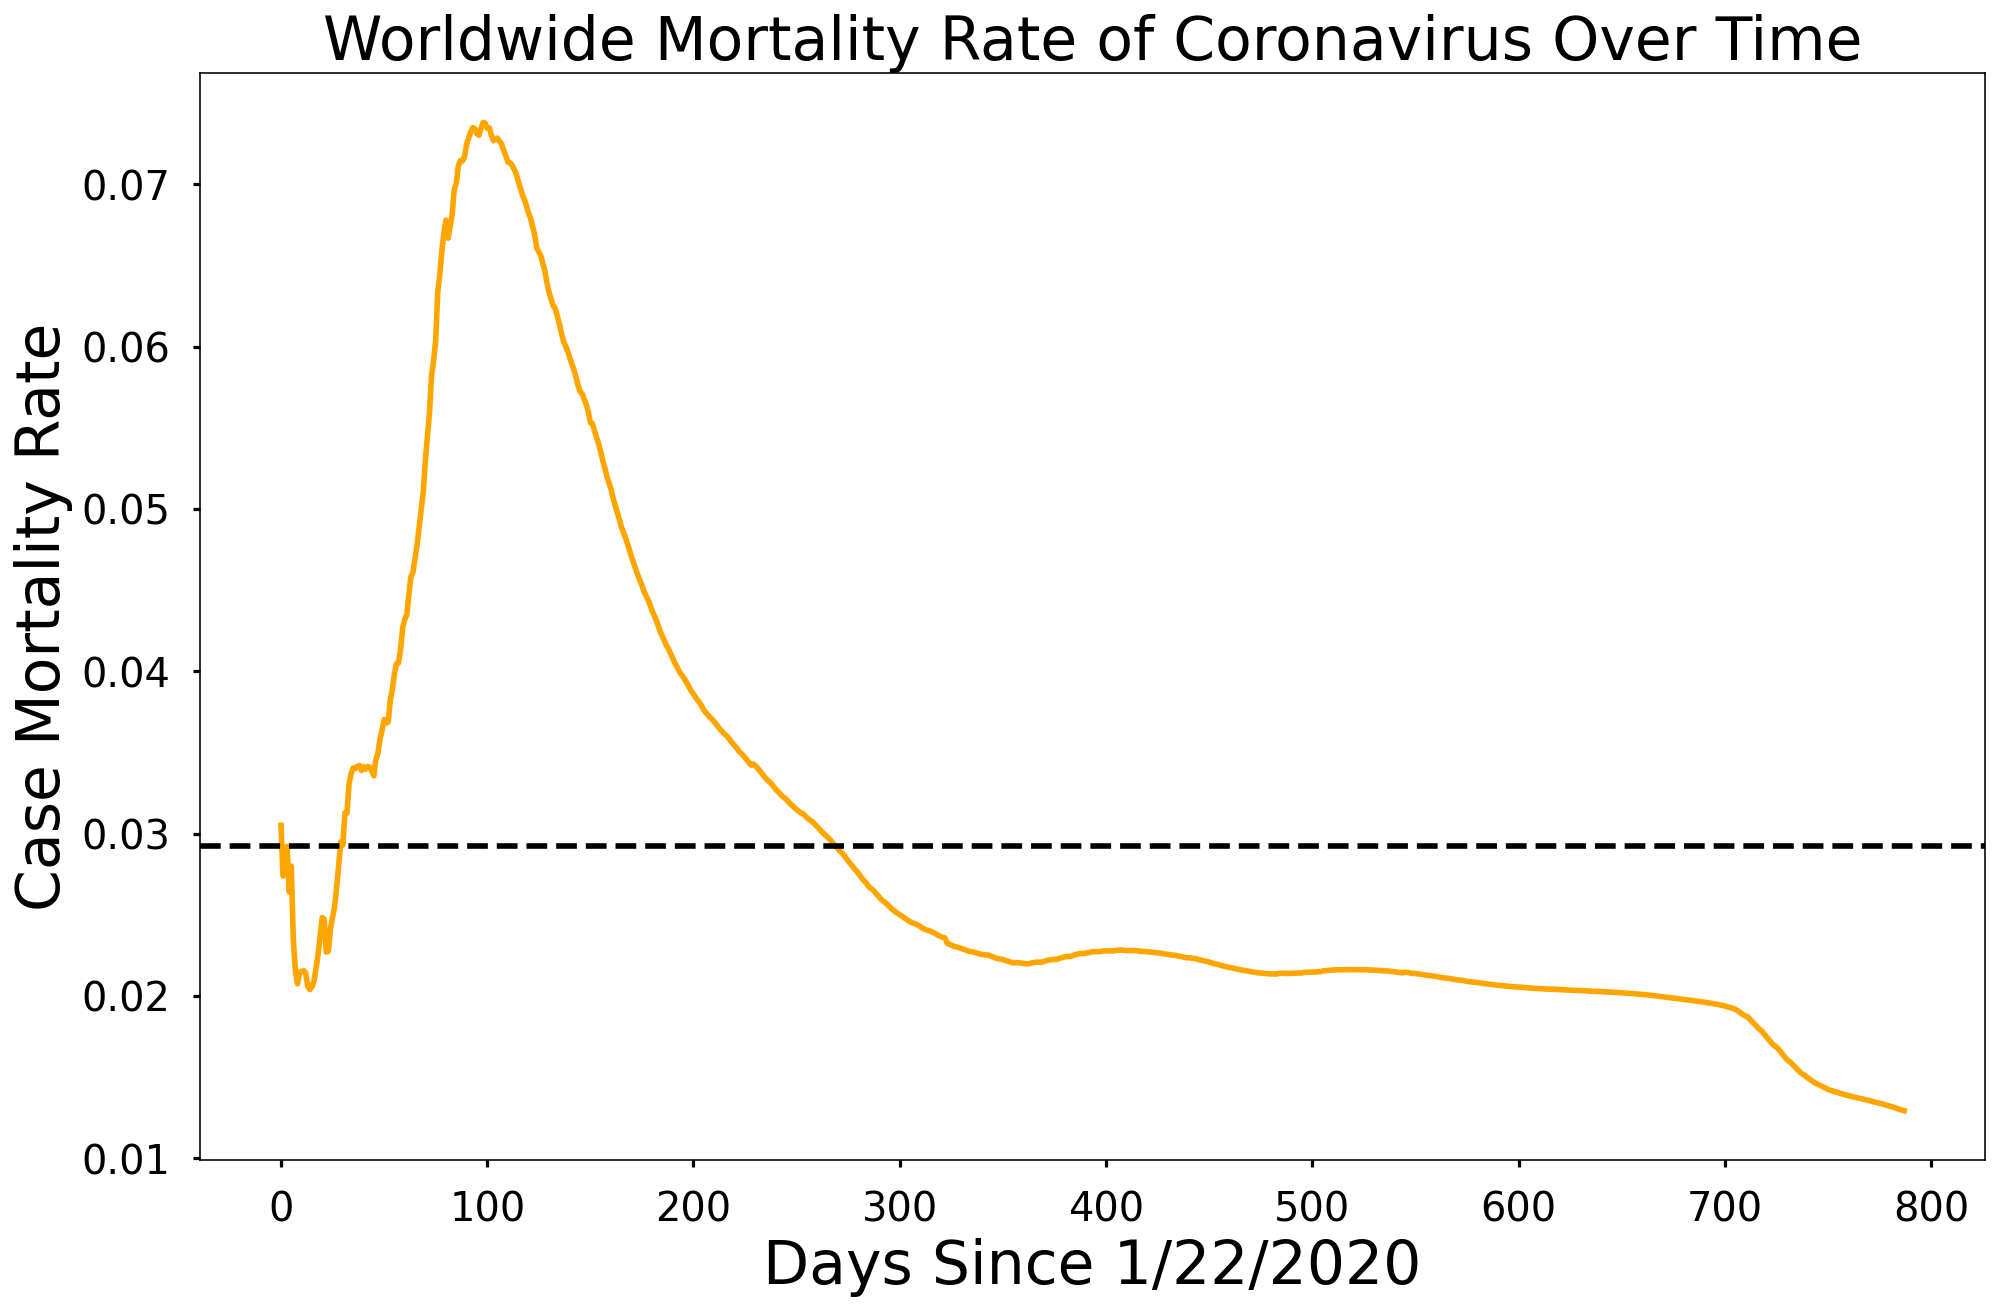

In [32]:
mean_mortality_rate = np.mean(mortality_rate)
plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, mortality_rate, color='orange')
plt.axhline(y = mean_mortality_rate,linestyle='--', color='black')
plt.title('Worldwide Mortality Rate of Coronavirus Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Case Mortality Rate', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [33]:
latest_data

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio
0,NaN,NaN,NaN,Afghanistan,2022-02-27 04:21:04,33.939110,67.709953,173146,7585,NaN,NaN,Afghanistan,444.781348,4.380696
1,NaN,NaN,NaN,Albania,2022-02-27 04:21:04,41.153300,20.168300,271141,3458,NaN,NaN,Albania,9421.815276,1.275351
2,NaN,NaN,NaN,Algeria,2022-02-27 04:21:04,28.033900,1.659600,264778,6828,NaN,NaN,Algeria,603.812320,2.578764
3,NaN,NaN,NaN,Andorra,2022-02-27 04:21:04,42.506300,1.521800,37999,151,NaN,NaN,Andorra,49180.094480,0.397379
4,NaN,NaN,NaN,Angola,2022-02-27 04:21:04,-11.202700,17.873900,98701,1899,NaN,NaN,Angola,300.310945,1.923993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4005,NaN,NaN,NaN,West Bank and Gaza,2022-02-27 04:21:04,31.952200,35.233200,640214,5458,NaN,NaN,West Bank and Gaza,12549.731290,0.852527
4006,NaN,NaN,NaN,Winter Olympics 2022,2022-02-27 04:21:04,39.904200,116.407400,514,0,NaN,NaN,Winter Olympics 2022,NaN,0.000000
4007,NaN,NaN,NaN,Yemen,2022-02-27 04:21:04,15.552727,48.516388,11760,2133,NaN,NaN,Yemen,39.428729,18.137755
4008,NaN,NaN,NaN,Zambia,2022-02-27 04:21:04,-13.133897,27.849332,312611,3951,NaN,NaN,Zambia,1700.455549,1.263871


In [34]:
unique_countries =  list(latest_data['Country_Region'].unique())

In [35]:
country_confirmed_cases = []
country_death_cases = [] 
country_incidence_rate = [] 
country_mortality_rate = [] 

no_cases = []
for i in unique_countries:
    cases = latest_data[latest_data['Country_Region']==i]['Confirmed'].sum()
    if cases > 0:
        country_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
        
for i in no_cases:
    unique_countries.remove(i)
    
# sort countries by the number of confirmed cases
unique_countries = [k for k, v in sorted(zip(unique_countries, country_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_countries)):
    country_confirmed_cases[i] = latest_data[latest_data['Country_Region']==unique_countries[i]]['Confirmed'].sum()
    country_death_cases.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Deaths'].sum())
    country_incidence_rate.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Incident_Rate'].sum())
    country_mortality_rate.append(country_death_cases[i]/country_confirmed_cases[i])

In [36]:
country_df = pd.DataFrame({'Country Name': unique_countries, 'Number of Confirmed Cases': [format(int(i), ',d') for i in country_confirmed_cases],
                          'Number of Deaths': [format(int(i), ',d') for i in country_death_cases], 
                          'Incidence Rate' : country_incidence_rate,
                          'Mortality Rate': country_mortality_rate})
# number of cases per country/region

country_df.style.background_gradient(cmap='Oranges')

,Country Name,Number of Confirmed Cases,Number of Deaths,Incidence Rate,Mortality Rate
0,US,"78,934,389","948,963",76247922.768127,0.012022
1,India,"42,916,117","513,724",191570.072760,0.011970
2,Brazil,"28,749,552","649,184",421746.041119,0.022581
3,France,"22,819,557","139,073",293151.530279,0.006094
4,United Kingdom,"18,938,546","161,797",346077.142897,0.008543
5,Russia,"15,941,241","343,178",899912.633750,0.021528
6,Germany,"14,732,722","122,692",278427.661335,0.008328
7,Turkey,"13,975,389","94,026",16570.480914,0.006728
8,Italy,"12,732,680","154,416",438762.371857,0.012128
9,Spain,"10,977,524","99,410",454868.825568,0.009056


In [37]:
unique_provinces =  list(latest_data['Province_State'].unique())

In [38]:
province_confirmed_cases = []
province_country = [] 
province_death_cases = []  
province_incidence_rate = []
province_mortality_rate = [] 

no_cases = [] 
for i in unique_provinces:
    cases = latest_data[latest_data['Province_State']==i]['Confirmed'].sum()
    if cases > 0:
        province_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
 
# remove areas with no confirmed cases
for i in no_cases:
    unique_provinces.remove(i)
    
unique_provinces = [k for k, v in sorted(zip(unique_provinces, province_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_provinces)):
    province_confirmed_cases[i] = latest_data[latest_data['Province_State']==unique_provinces[i]]['Confirmed'].sum()
    province_country.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Country_Region'].unique()[0])
    province_death_cases.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Deaths'].sum())
    province_incidence_rate.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Incident_Rate'].sum())
    province_mortality_rate.append(province_death_cases[i]/province_confirmed_cases[i])

In [39]:
province_limit = 100 
province_df = pd.DataFrame({'Province/State Name': unique_provinces[:province_limit], 'Country': province_country[:province_limit], 'Number of Confirmed Cases': [format(int(i), ',d') for i in province_confirmed_cases[:province_limit]],
                          'Number of Deaths': [format(int(i), ',d') for i in province_death_cases[:province_limit]], 
                        'Incidence Rate' : province_incidence_rate[:province_limit], 'Mortality Rate': province_mortality_rate[:province_limit]})
# number of cases per country/region

province_df.style.background_gradient(cmap='Oranges')

,Province/State Name,Country,Number of Confirmed Cases,Number of Deaths,Incidence Rate,Mortality Rate
0,England,United Kingdom,"15,998,983","140,392",28581.249151,0.008775
1,California,US,"8,962,164","85,040",1182147.392039,0.009489
2,Maharashtra,India,"7,864,516","143,695",6386.427076,0.018271
3,Texas,US,"6,612,192","84,775",5792049.742493,0.012821
4,Kerala,India,"6,494,680","65,161",18192.664799,0.010033
5,Florida,US,"5,844,229","69,790",1707977.857546,0.011942
6,Sao Paulo,Brazil,"5,010,949","164,516",10912.571382,0.032831
7,New York,US,"4,921,916","67,300",1316519.880677,0.013674
8,Karnataka,India,"3,940,429","39,919",5832.256284,0.010131
9,Tamil Nadu,India,"3,448,568","38,002",4430.256769,0.011020


In [40]:
def country_table(country_name):
    states = list(latest_data[latest_data['Country_Region']==country_name]['Province_State'].unique())
    state_confirmed_cases = []
    state_death_cases = [] 
    state_incidence_rate = [] 
    state_mortality_rate = [] 

    no_cases = [] 
    for i in states:
        cases = latest_data[latest_data['Province_State']==i]['Confirmed'].sum()
        if cases > 0:
            state_confirmed_cases.append(cases)
        else:
            no_cases.append(i)

    # remove areas with no confirmed cases
    for i in no_cases:
        states.remove(i)

    states = [k for k, v in sorted(zip(states, state_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
    for i in range(len(states)):
        state_confirmed_cases[i] = latest_data[latest_data['Province_State']==states[i]]['Confirmed'].sum()
        state_death_cases.append(latest_data[latest_data['Province_State']==states[i]]['Deaths'].sum())
        state_incidence_rate.append(latest_data[latest_data['Province_State']==states[i]]['Incident_Rate'].sum())
        state_mortality_rate.append(state_death_cases[i]/state_confirmed_cases[i])
        
      
    state_df = pd.DataFrame({'State Name': states, 'Number of Confirmed Cases': [format(int(i), ',d') for i in state_confirmed_cases],
                              'Number of Deaths': [format(int(i), ',d') for i in state_death_cases], 
                             'Incidence Rate' : state_incidence_rate, 'Mortality Rate': state_mortality_rate})
    # number of cases per country/region
    return state_df

In [41]:
us_table = country_table('US')
us_table.style.background_gradient(cmap='Oranges')

,State Name,Number of Confirmed Cases,Number of Deaths,Incidence Rate,Mortality Rate
0,California,"8,962,164","85,040",1182147.392039,0.009489
1,Texas,"6,612,192","84,775",5792049.742493,0.012821
2,Florida,"5,844,229","69,790",1707977.857546,0.011942
3,New York,"4,921,916","67,300",1316519.880677,0.013674
4,Illinois,"3,026,737","35,087",2875660.415592,0.011592
5,Pennsylvania,"2,755,730","43,203",1494687.961498,0.015678
6,Ohio,"2,652,634","37,328",2058579.265518,0.014072
7,North Carolina,"2,583,404","22,500",2442784.626484,0.008709
8,Georgia,"2,462,663","35,316",3636333.060437,0.014341
9,Michigan,"2,357,955","34,477",1822620.371938,0.014622


In [42]:
india_table = country_table('India')
india_table.style.background_gradient(cmap='Oranges')

,State Name,Number of Confirmed Cases,Number of Deaths,Incidence Rate,Mortality Rate
0,Maharashtra,"7,864,516","143,695",6386.427076,0.018271
1,Kerala,"6,494,680","65,161",18192.664799,0.010033
2,Karnataka,"3,940,429","39,919",5832.256284,0.010131
3,Tamil Nadu,"3,448,568","38,002",4430.256769,0.011020
4,Andhra Pradesh,"2,317,605","14,725",4299.553091,0.006354
5,Uttar Pradesh,"2,067,138","23,450",868.973567,0.011344
6,West Bengal,"2,014,803","21,172",2022.705650,0.010508
7,Delhi,"1,859,054","26,119",9935.662176,0.014050
8,Odisha,"1,284,616","9,056",2771.176858,0.007050
9,Rajasthan,"1,279,003","9,535",1578.379066,0.007455


In [43]:
brazil_table = country_table('Brazil')
brazil_table.style.background_gradient(cmap='Oranges')

,State Name,Number of Confirmed Cases,Number of Deaths,Incidence Rate,Mortality Rate
0,Sao Paulo,"5,010,949","164,516",10912.571382,0.032831
1,Minas Gerais,"3,193,975","59,589",15088.131391,0.018657
2,Parana,"2,325,021","42,281",20334.351441,0.018185
3,Rio Grande do Sul,"2,151,960","38,259",18914.606611,0.017779
4,Rio de Janeiro,"1,993,810","71,723",11548.314987,0.035973
5,Santa Catarina,"1,613,315","21,347",22517.274761,0.013232
6,Bahia,"1,501,100","29,143",10092.742155,0.019414
7,Ceara,"1,226,040","26,286",13425.640911,0.021440
8,Goias,"1,166,106","25,738",16615.092371,0.022072
9,Espirito Santo,"1,021,032","14,114",25407.338285,0.013823


In [44]:
russia_table = country_table('Russia')
russia_table.style.background_gradient(cmap='Oranges')

,State Name,Number of Confirmed Cases,Number of Deaths,Incidence Rate,Mortality Rate
0,Moscow,"2,691,110","41,115",21517.745858,0.015278
1,Saint Petersburg,"1,425,944","31,732",26643.522390,0.022253
2,Moscow Oblast,"936,667","14,152",12483.259222,0.015109
3,Nizhny Novgorod Oblast,"355,079","11,074",10977.008438,0.031187
4,Sverdlovsk Oblast,"341,037","10,245",7884.781849,0.030041
5,Krasnoyarsk Krai,"332,870","9,942",11572.061434,0.029868
6,Voronezh Oblast,"323,971","7,560",13881.885432,0.023335
7,Samara Oblast,"317,690","7,070",9947.975803,0.022254
8,Rostov Oblast,"315,242","10,303",7469.389535,0.032683
9,Perm Krai,"309,515","8,301",11799.489311,0.026819


In [45]:
ukraine_table = country_table('Ukraine')
ukraine_table.style.background_gradient(cmap='Oranges')

,State Name,Number of Confirmed Cases,Number of Deaths,Incidence Rate,Mortality Rate
0,Kiev,"445,098","8,966",15083.977227,0.020144
1,Odessa Oblast,"325,462","5,917",13673.104489,0.018180
2,Kharkiv Oblast,"305,661","6,858",11424.025582,0.022437
3,Dnipropetrovsk Oblast,"303,551","9,454",9466.807340,0.031145
4,Lviv Oblast,"303,357","6,569",12028.329661,0.021654
5,Kiev Oblast,"226,220","5,019",12795.683111,0.022186
6,Donetsk Oblast,"216,052","5,607",5186.201016,0.025952
7,Zaporizhia Oblast,"215,070","5,866",12607.894311,0.027275
8,Khmelnytskyi Oblast,"201,270","3,703",15914.383196,0.018398
9,Zhytomyr Oblast,"192,801","3,538",15800.861011,0.018351


In [46]:

france_table = country_table('France')
france_table.style.background_gradient(cmap='Oranges')

,State Name,Number of Confirmed Cases,Number of Deaths,Incidence Rate,Mortality Rate
0,Reunion,"292,126",640,32628.547941,0.002191
1,Guadeloupe,"122,211",909,30543.052581,0.007438
2,Martinique,"112,115",871,29876.220804,0.007769
3,French Guiana,"77,625",391,25989.179127,0.005037
4,French Polynesia,"65,583",638,23347.122148,0.009728
5,New Caledonia,"53,007",299,18566.960079,0.005641
6,Mayotte,"36,631",187,13427.146067,0.005105
7,St Martin,"9,877",63,25549.031273,0.006378
8,Saint Barthelemy,"3,758",6,38017.197774,0.001597
9,Saint Pierre and Miquelon,"1,070",1,18464.193270,0.000935


In [47]:
italy_table = country_table('Italy')
italy_table.style.background_gradient(cmap='Oranges')

,State Name,Number of Confirmed Cases,Number of Deaths,Incidence Rate,Mortality Rate
0,Lombardia,"2,327,840","38,537",23138.242410,0.016555
1,Veneto,"1,325,721","13,814",27023.246106,0.010420
2,Campania,"1,201,866","9,725",20715.784292,0.008092
3,Emilia-Romagna,"1,182,462","15,874",26515.710250,0.013425
4,Lazio,"1,068,456","10,407",18173.857755,0.009740
5,Piemonte,"975,614","13,023",22394.928296,0.013349
6,Toscana,"852,932","8,980",22869.010717,0.010528
7,Sicilia,"779,780","9,424",15595.939991,0.012085
8,Puglia,"730,126","7,636",18121.528806,0.010458
9,Liguria,"343,761","5,090",22168.975391,0.014807


In [48]:

spain_table = country_table('Spain')
spain_table.style.background_gradient(cmap='Oranges')

,State Name,Number of Confirmed Cases,Number of Deaths,Incidence Rate,Mortality Rate
0,Catalonia,"2,259,638","17,913",29863.987394,0.007927
1,Madrid,"1,588,644","17,373",23919.421216,0.010936
2,Andalusia,"1,338,709","12,741",15885.186484,0.009517
3,C. Valenciana,"1,290,406","8,995",25937.970669,0.006971
4,Castilla y Leon,"649,178","8,204",26962.208850,0.012638
5,Pais Vasco,"648,855","6,142",29792.963800,0.009466
6,Galicia,"524,681","3,081",19429.456152,0.005872
7,Castilla - La Mancha,"469,366","7,064",23066.062470,0.015050
8,Aragon,"395,265","4,811",29931.030618,0.012172
9,Murcia,"370,238","2,154",24887.222442,0.005818


In [49]:
germany_table = country_table('Germany')
germany_table.style.background_gradient(cmap='Oranges')

,State Name,Number of Confirmed Cases,Number of Deaths,Incidence Rate,Mortality Rate
0,Nordrhein-Westfalen,"3,034,867","22,206",16923.694104,0.007317
1,Bayern,"2,748,972","21,314",21021.875438,0.007753
2,Baden-Wurttemberg,"2,077,310","14,244",18766.012984,0.006857
3,Hessen,"1,059,416","9,176",16907.888510,0.008661
4,Niedersachsen,"1,035,957","7,447",12977.936092,0.007189
5,Sachsen,"928,160","14,295",22760.528179,0.015401
6,Berlin,"735,209","4,243",20171.305846,0.005771
7,Rheinland-Pfalz,"572,593","4,996",14017.499811,0.008725
8,Brandenburg,"511,358","5,180",20357.280913,0.010130
9,Thuringen,"408,158","6,604",19044.814980,0.016180


In [50]:
netherlands_table = country_table('Netherlands')
netherlands_table.style.background_gradient(cmap='Oranges')

,State Name,Number of Confirmed Cases,Number of Deaths,Incidence Rate,Mortality Rate
0,Zuid-Holland,"1,386,496","4,975",36317.293194,0.003588
1,Noord-Holland,"1,065,708","3,247",35446.134035,0.003047
2,Noord-Brabant,"943,197","3,568",35212.635415,0.003783
3,Gelderland,"744,648","2,685",34437.034026,0.003606
4,Limburg,"647,541","2,103",63075.184480,0.003248
5,Utrecht,"523,047","1,504",37302.503480,0.002875
6,Overijssel,"427,933","1,374",35496.203564,0.003211
7,Friesland,"210,225",596,30966.202380,0.002835
8,Groningen,"177,315",338,28954.061168,0.001906
9,Flevoland,"149,620",323,34409.166448,0.002159


In [51]:
china_table = country_table('China')
china_table.style.background_gradient(cmap='Oranges')

,State Name,Number of Confirmed Cases,Number of Deaths,Incidence Rate,Mortality Rate
0,Hong Kong,"168,590",577,592.051101,0.003423
1,Unknown,"112,125","31,358",0.000000,0.279670
2,Hubei,"68,349","4,512",115.512929,0.066014
3,Guangdong,"4,517",8,3.981139,0.001771
4,Shanghai,"4,265",7,17.594884,0.001641
5,Shaanxi,"2,826",3,7.313665,0.001062
6,Henan,"2,664",22,2.773555,0.008258
7,Zhejiang,"2,265",1,3.948056,0.000442
8,Heilongjiang,"2,072",13,5.491651,0.006274
9,Yunnan,"1,943",2,4.022774,0.001029


# Bar Chart Visualizations for COVID-19




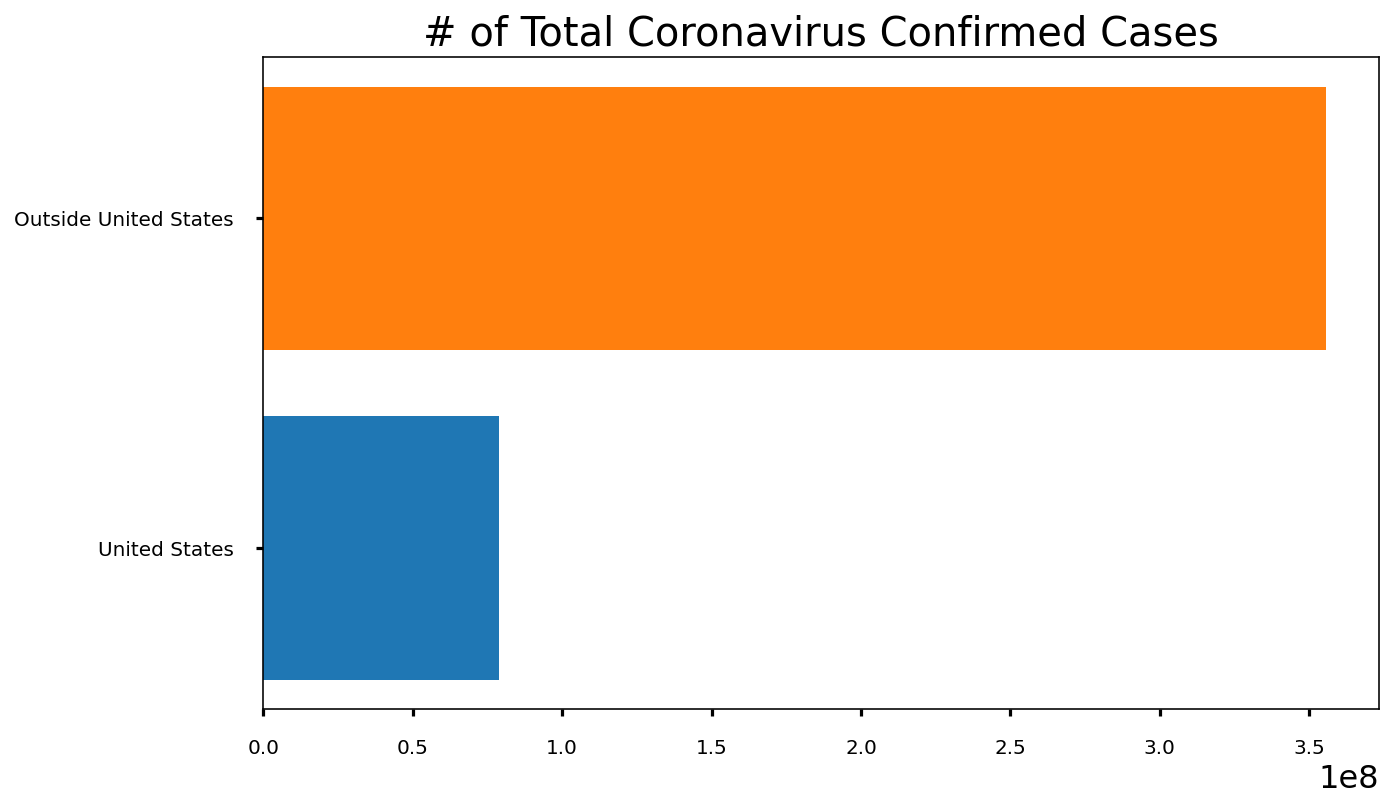

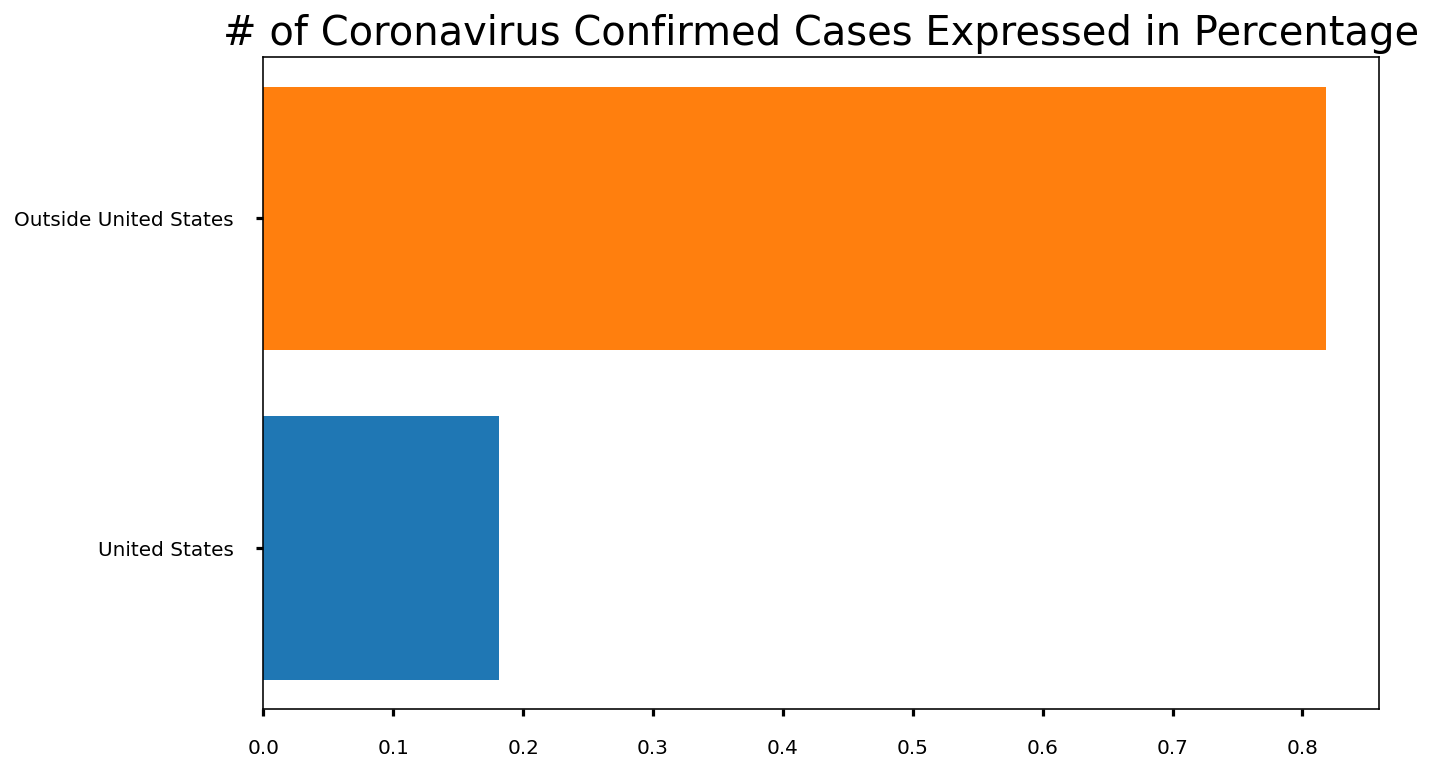

In [52]:
total_world_cases = np.sum(country_confirmed_cases)
us_confirmed = latest_data[latest_data['Country_Region']=='US']['Confirmed'].sum()
outside_us_confirmed = total_world_cases - us_confirmed

plt.figure(figsize=(10, 6))
plt.barh('United States', us_confirmed)
plt.barh('Outside United States', outside_us_confirmed)
plt.title('# of Total Coronavirus Confirmed Cases', size=20)
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()


plt.figure(figsize=(10, 6))
plt.barh('United States', us_confirmed/total_world_cases)
plt.barh('Outside United States', outside_us_confirmed/total_world_cases)
plt.title('# of Coronavirus Confirmed Cases Expressed in Percentage', size=20)
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

In [53]:
print('Outside United States {} cases ({}%):'.format(outside_us_confirmed, np.round((outside_us_confirmed/total_world_cases)*100, 1)))
print('United States {} cases ({}%)'.format(us_confirmed, np.round((us_confirmed/total_world_cases)*100, 1)))
print('Total: {} cases'.format(total_world_cases))

Outside United States 355690236 cases (81.8%):
United States 78934389 cases (18.2%)
Total: 434624625 cases


In [54]:
# Only show 10 countries with the most confirmed cases, 
# the rest are grouped into the other category

visual_unique_countries = [] 
visual_confirmed_cases = []
others = np.sum(country_confirmed_cases[10:])

for i in range(len(country_confirmed_cases[:10])):
    visual_unique_countries.append(unique_countries[i])
    visual_confirmed_cases.append(country_confirmed_cases[i])
    
visual_unique_countries.append('Others')
visual_confirmed_cases.append(others)

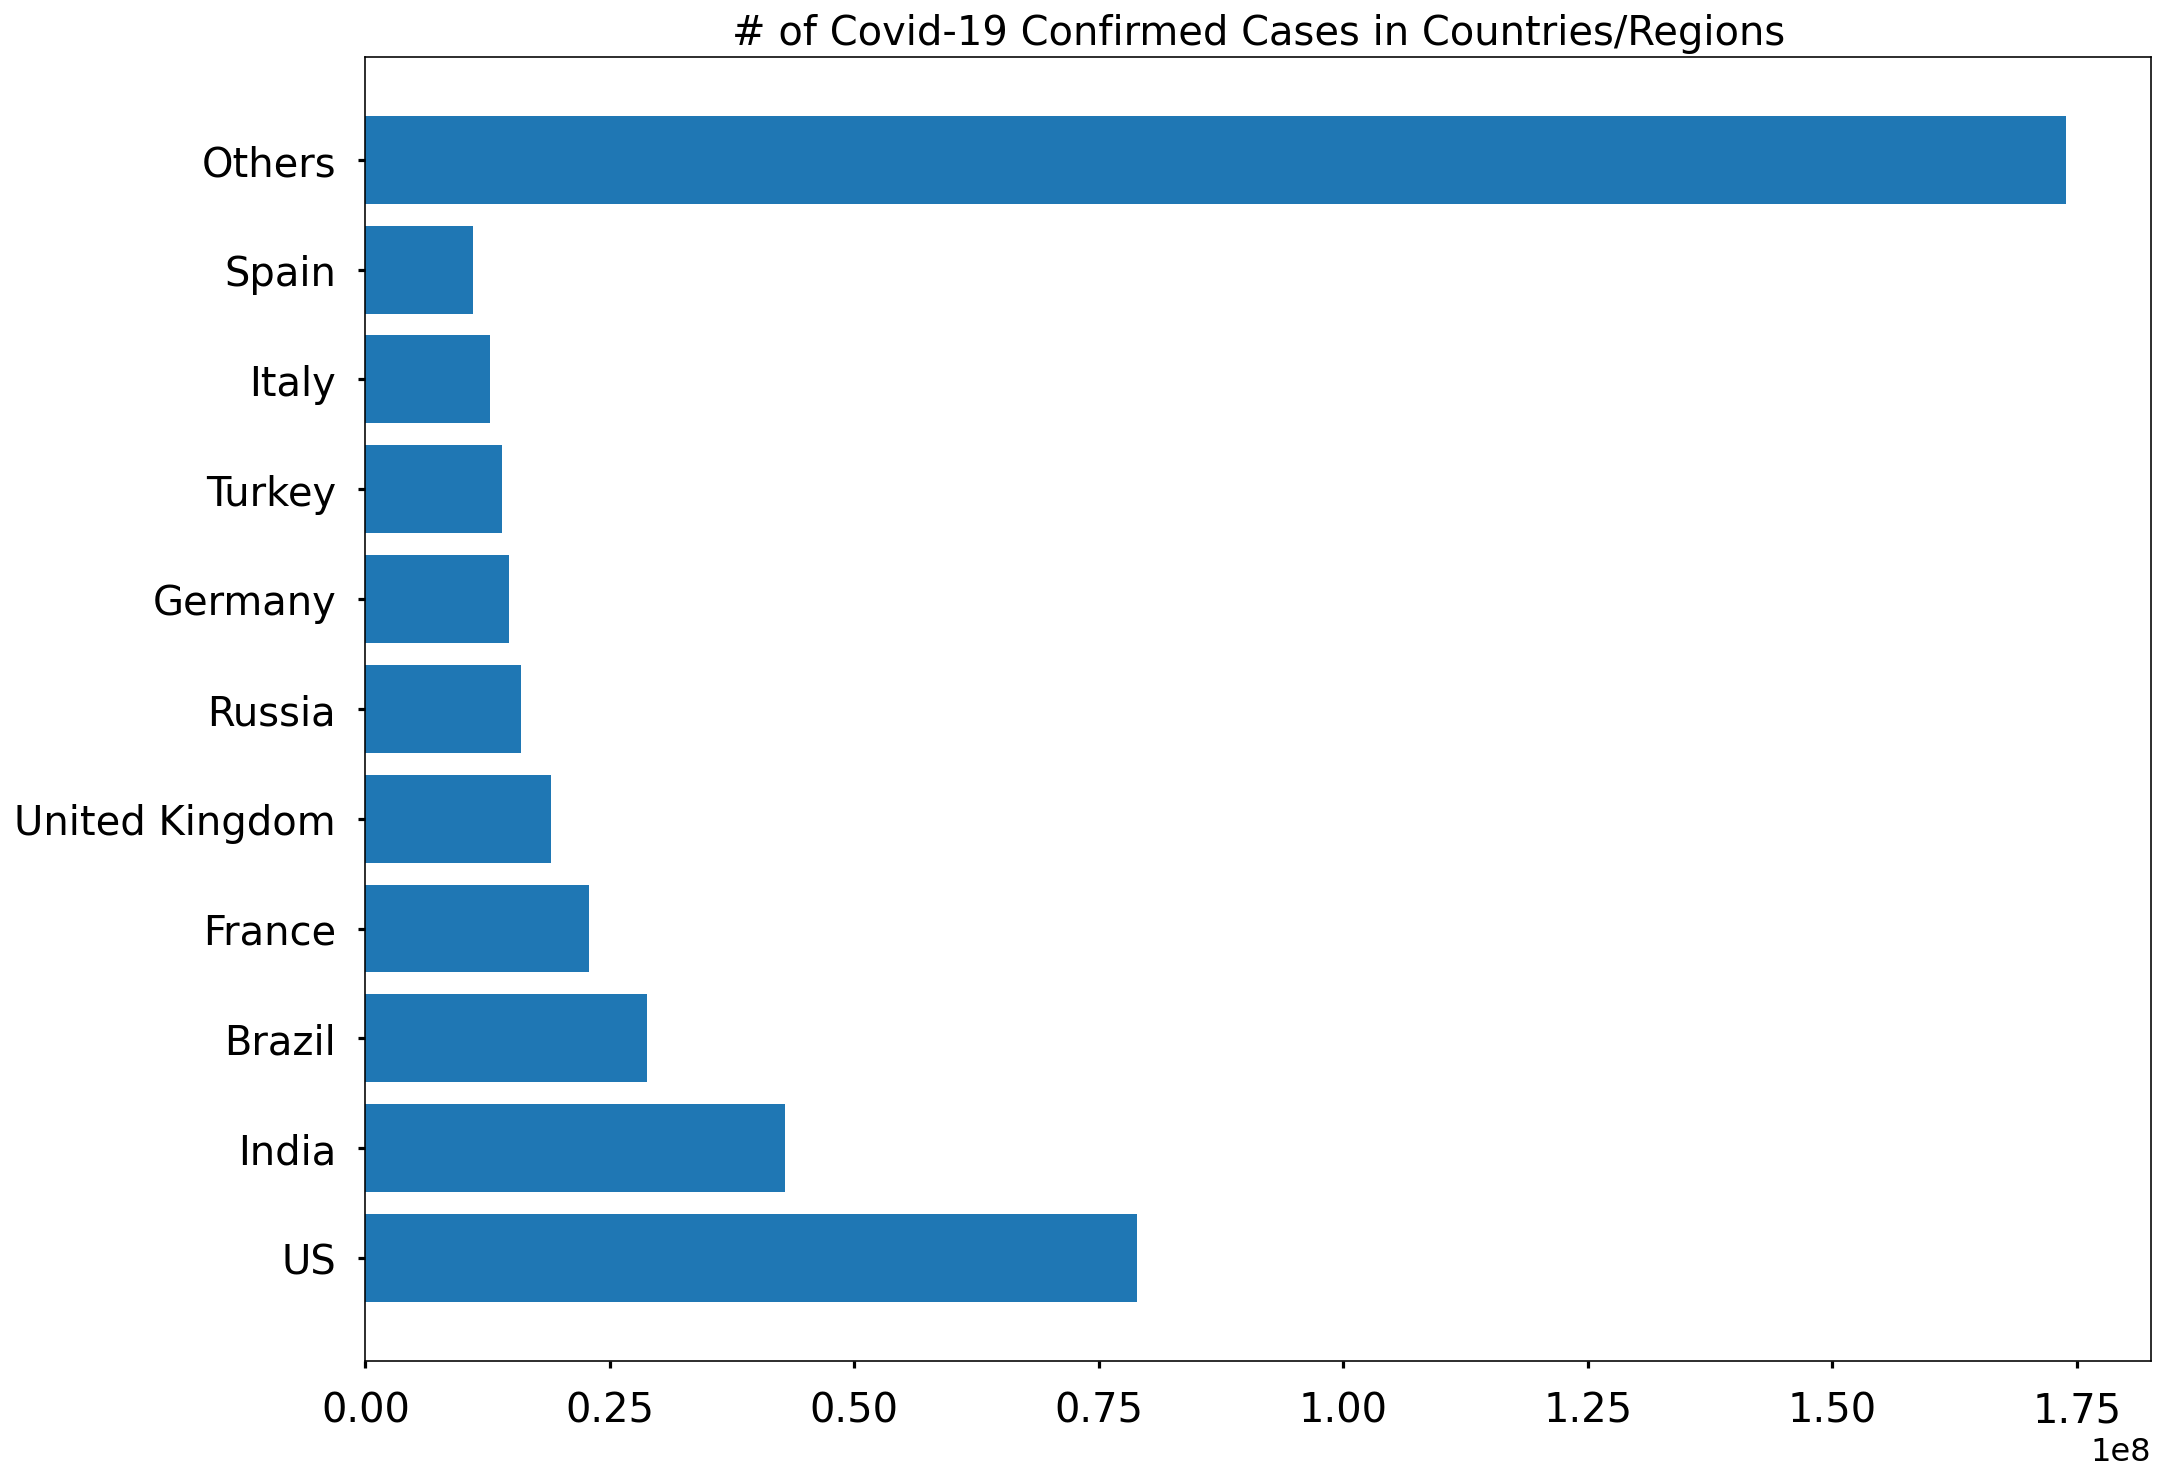

In [55]:
def plot_bar_graphs(x, y, title):
    plt.figure(figsize=(16, 12))
    plt.barh(x, y)
    plt.title(title, size=20)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()
    
# good for a lot x values 
def plot_bar_graphs_tall(x, y, title):
    plt.figure(figsize=(19, 18))
    plt.barh(x, y)
    plt.title(title, size=25)
    plt.xticks(size=25)
    plt.yticks(size=25)
    plt.show()


plot_bar_graphs(visual_unique_countries, visual_confirmed_cases, '# of Covid-19 Confirmed Cases in Countries/Regions')

In [56]:
# Only show 10 provinces with the most confirmed cases, the rest are grouped into the other category
visual_unique_provinces = [] 
visual_confirmed_cases2 = []
others = np.sum(province_confirmed_cases[10:])
for i in range(len(province_confirmed_cases[:10])):
    visual_unique_provinces.append(unique_provinces[i])
    visual_confirmed_cases2.append(province_confirmed_cases[i])

visual_unique_provinces.append('Others')
visual_confirmed_cases2.append(others)

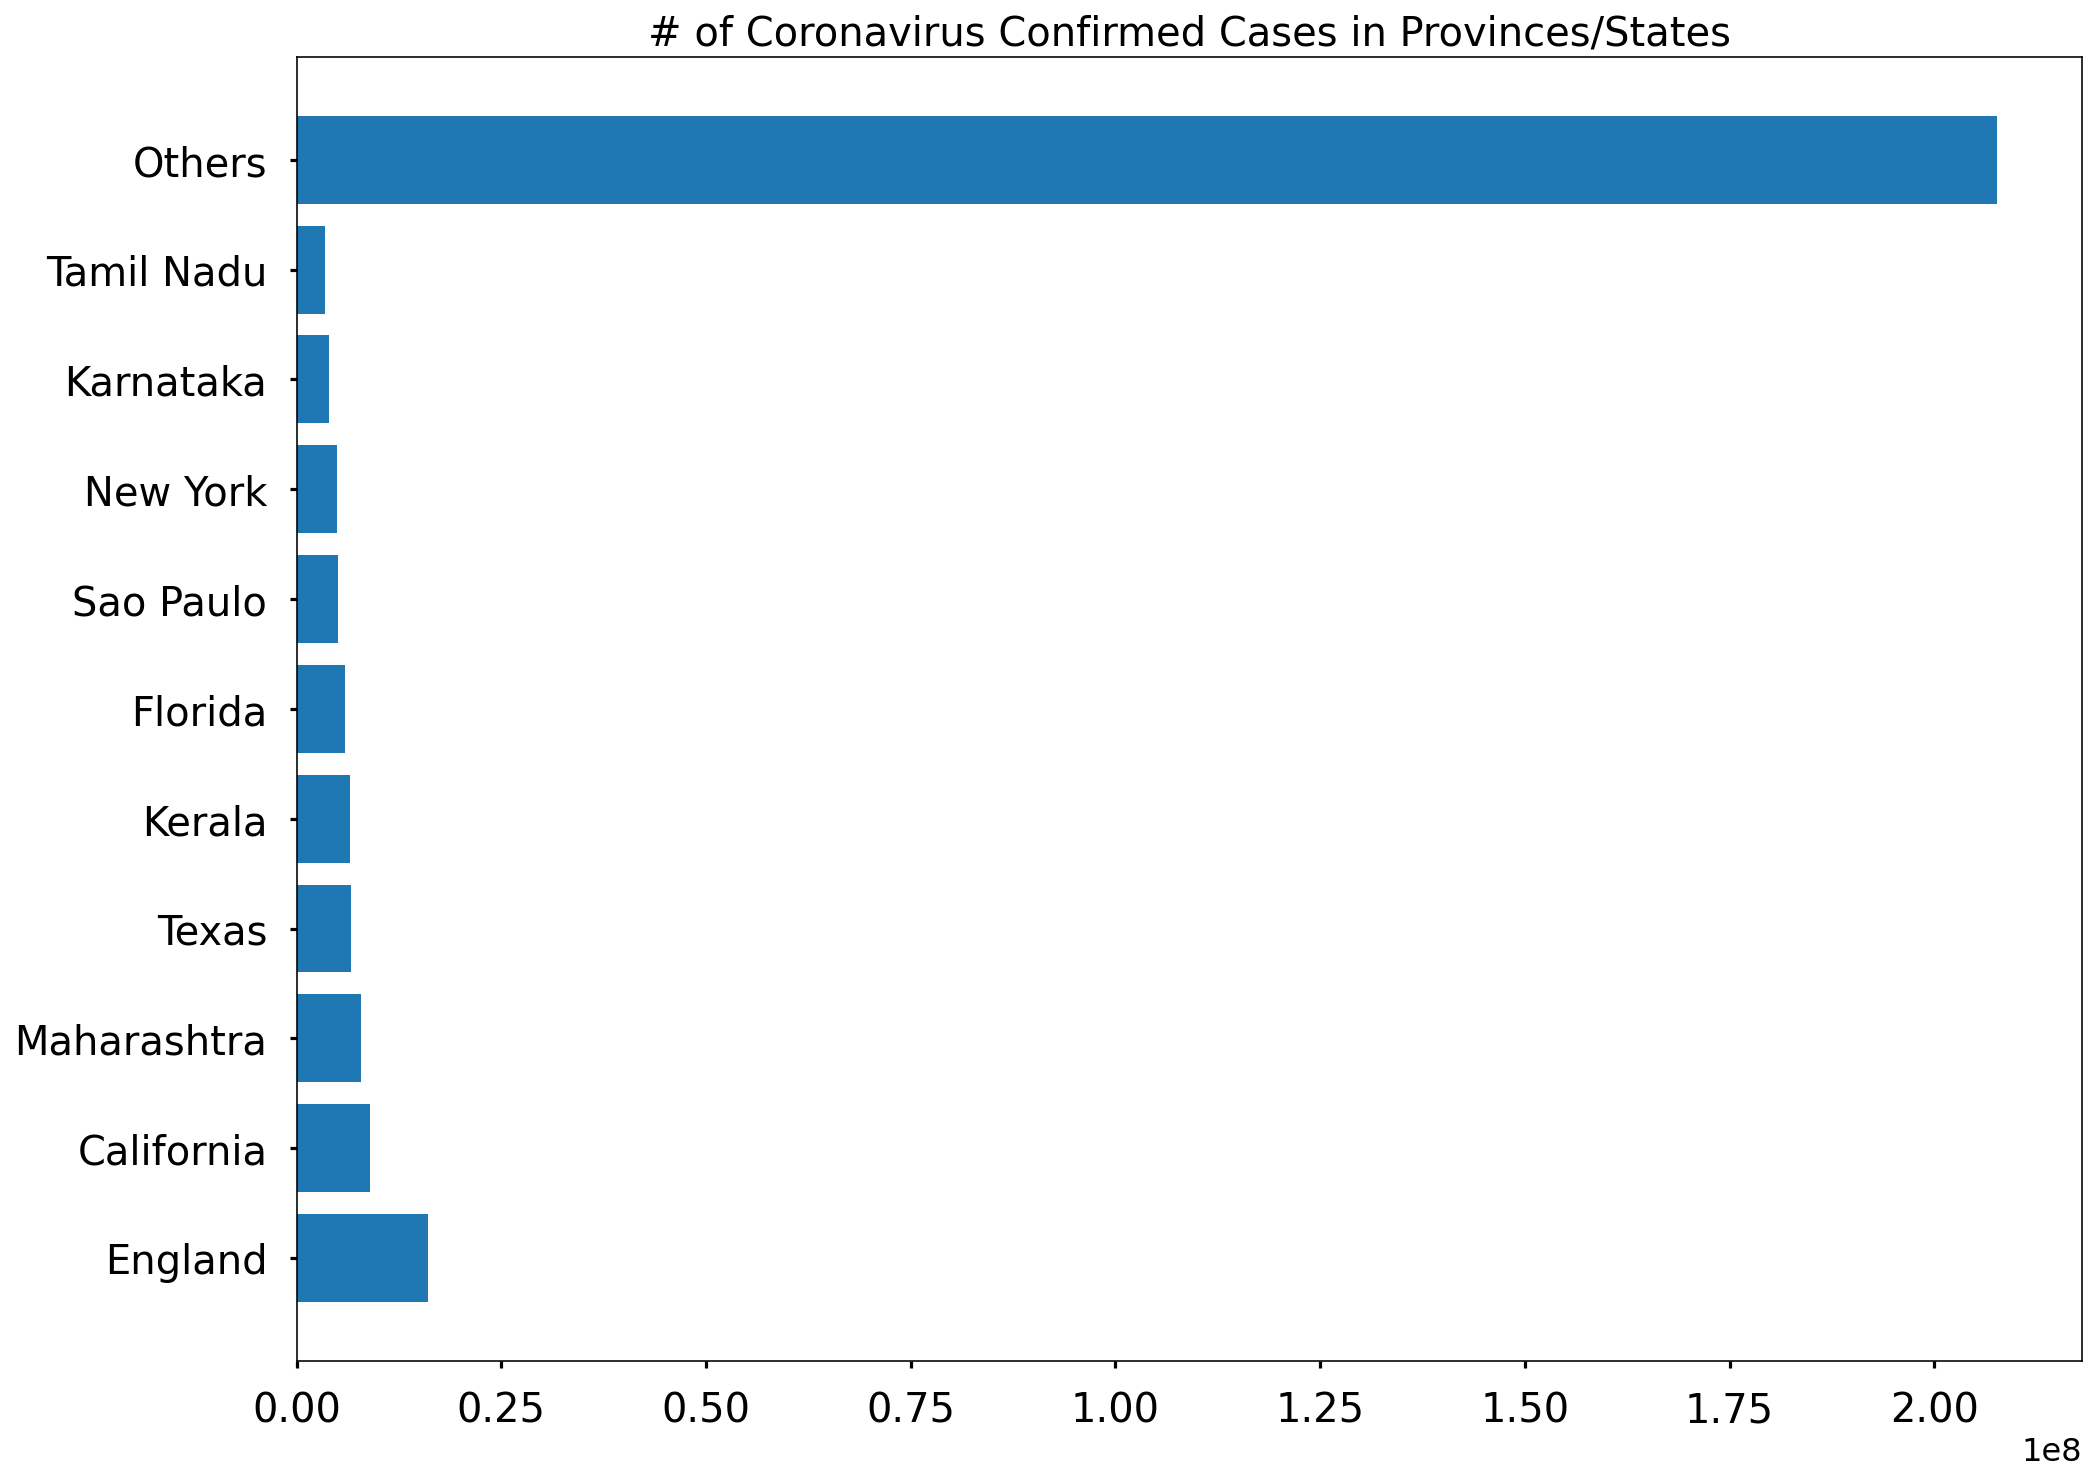

In [57]:
plot_bar_graphs(visual_unique_provinces, visual_confirmed_cases2, '# of Coronavirus Confirmed Cases in Provinces/States')

# Pie Chart Visualizations for COVID-19

In [58]:
def plot_pie_charts(x, y, title):
    # more muted color 
    c = ['lightcoral', 'rosybrown', 'sandybrown', 'navajowhite', 'gold',
        'khaki', 'lightskyblue', 'turquoise', 'lightslategrey', 'thistle', 'pink']
    plt.figure(figsize=(20,15))
    plt.title(title, size=20)
    plt.pie(y, colors=c,shadow=True)
    plt.legend(x, loc='best', fontsize=12)
    plt.show()

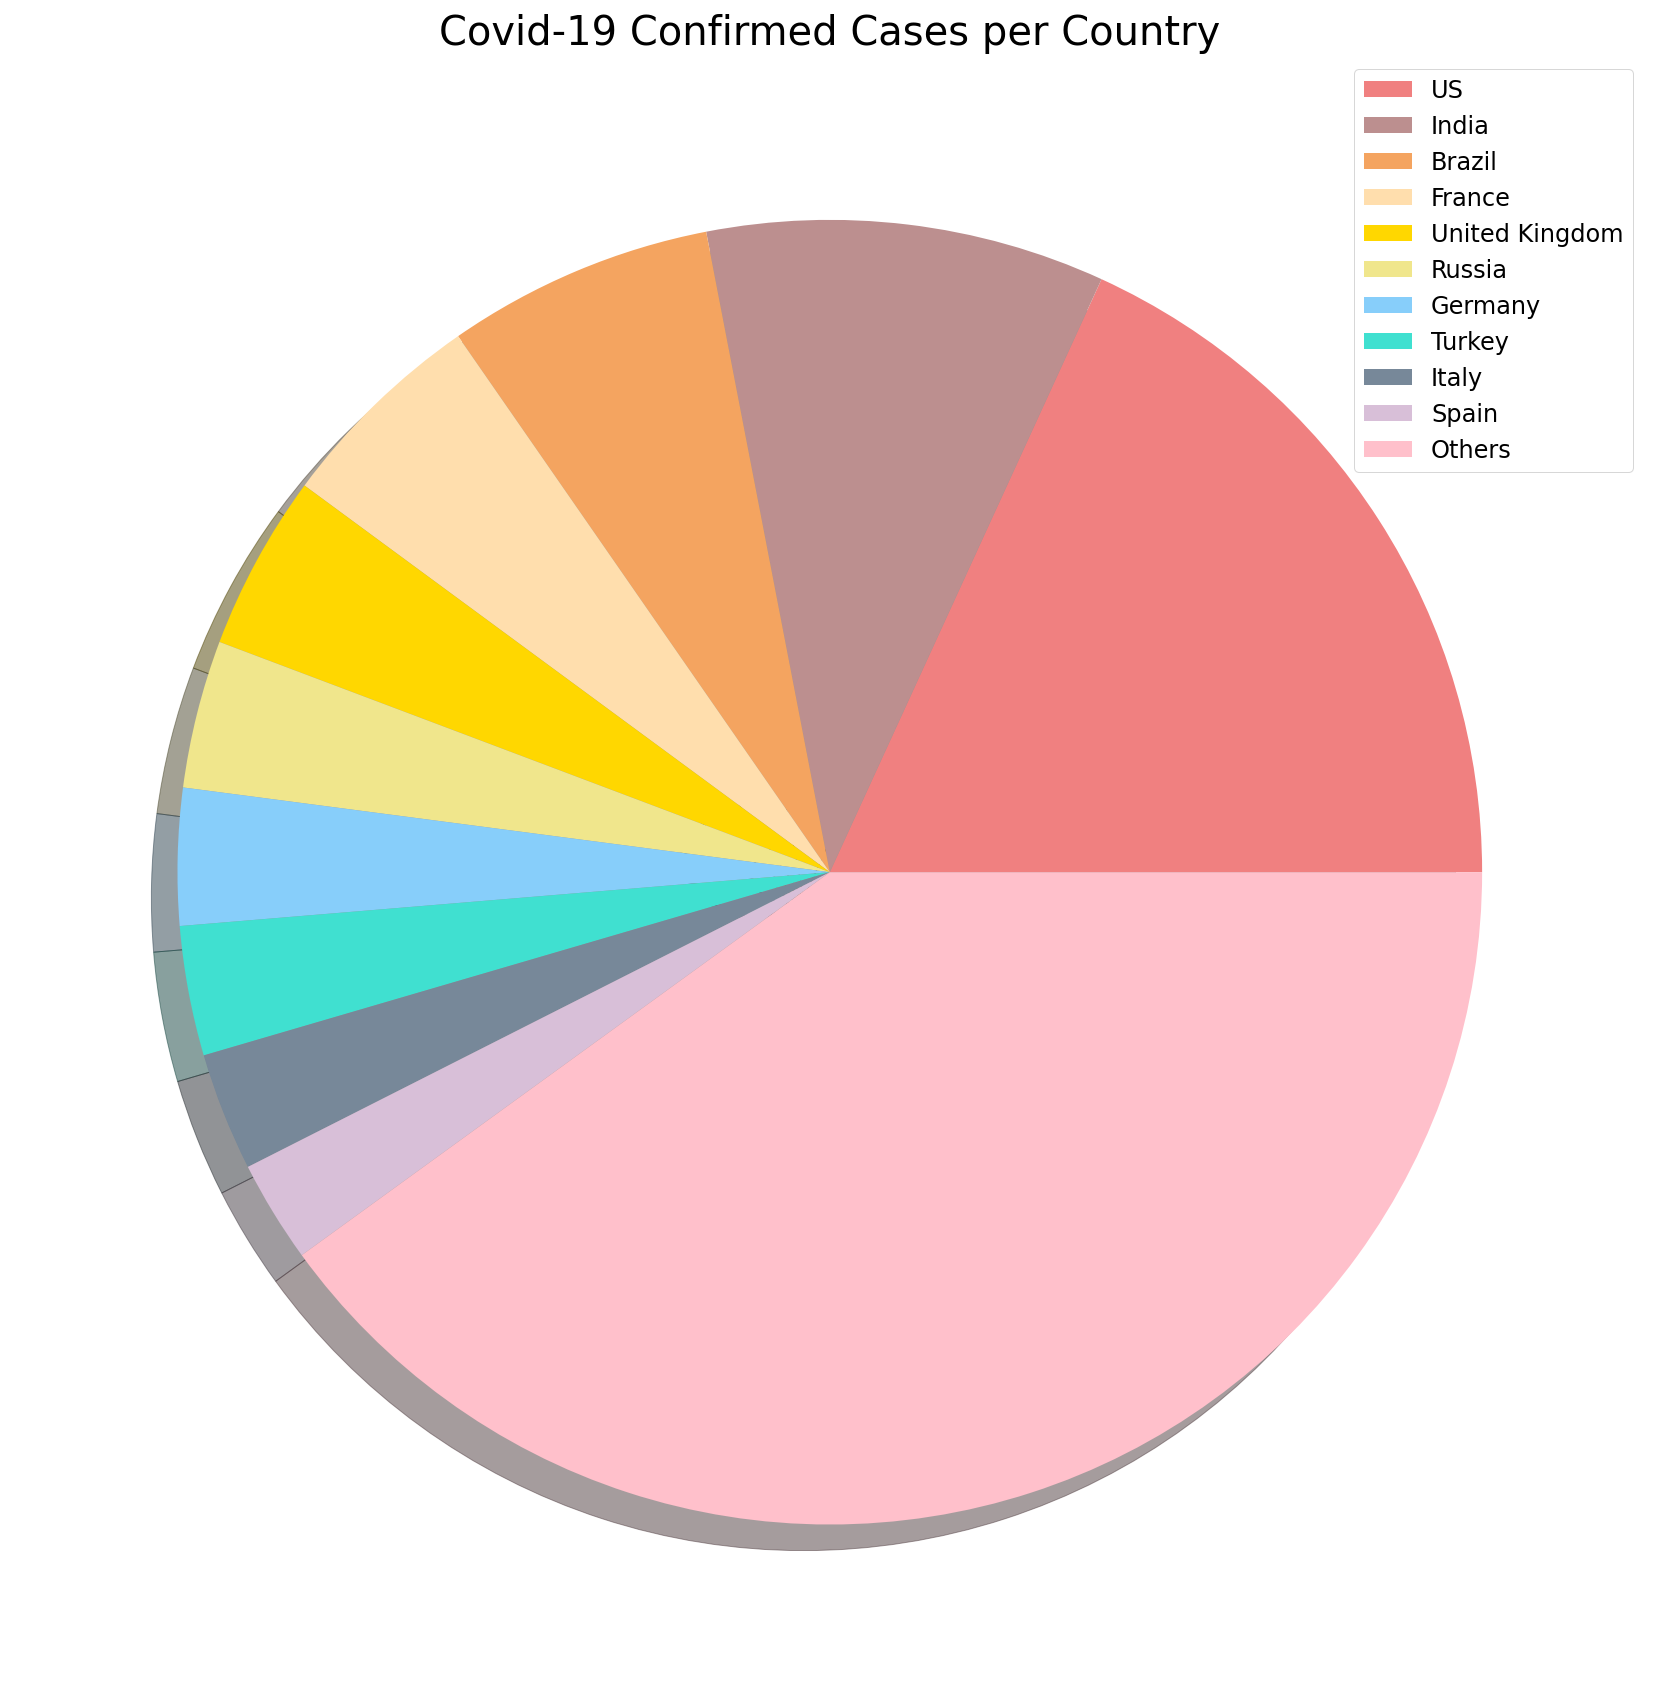

In [59]:
plot_pie_charts(visual_unique_countries, visual_confirmed_cases, 'Covid-19 Confirmed Cases per Country')

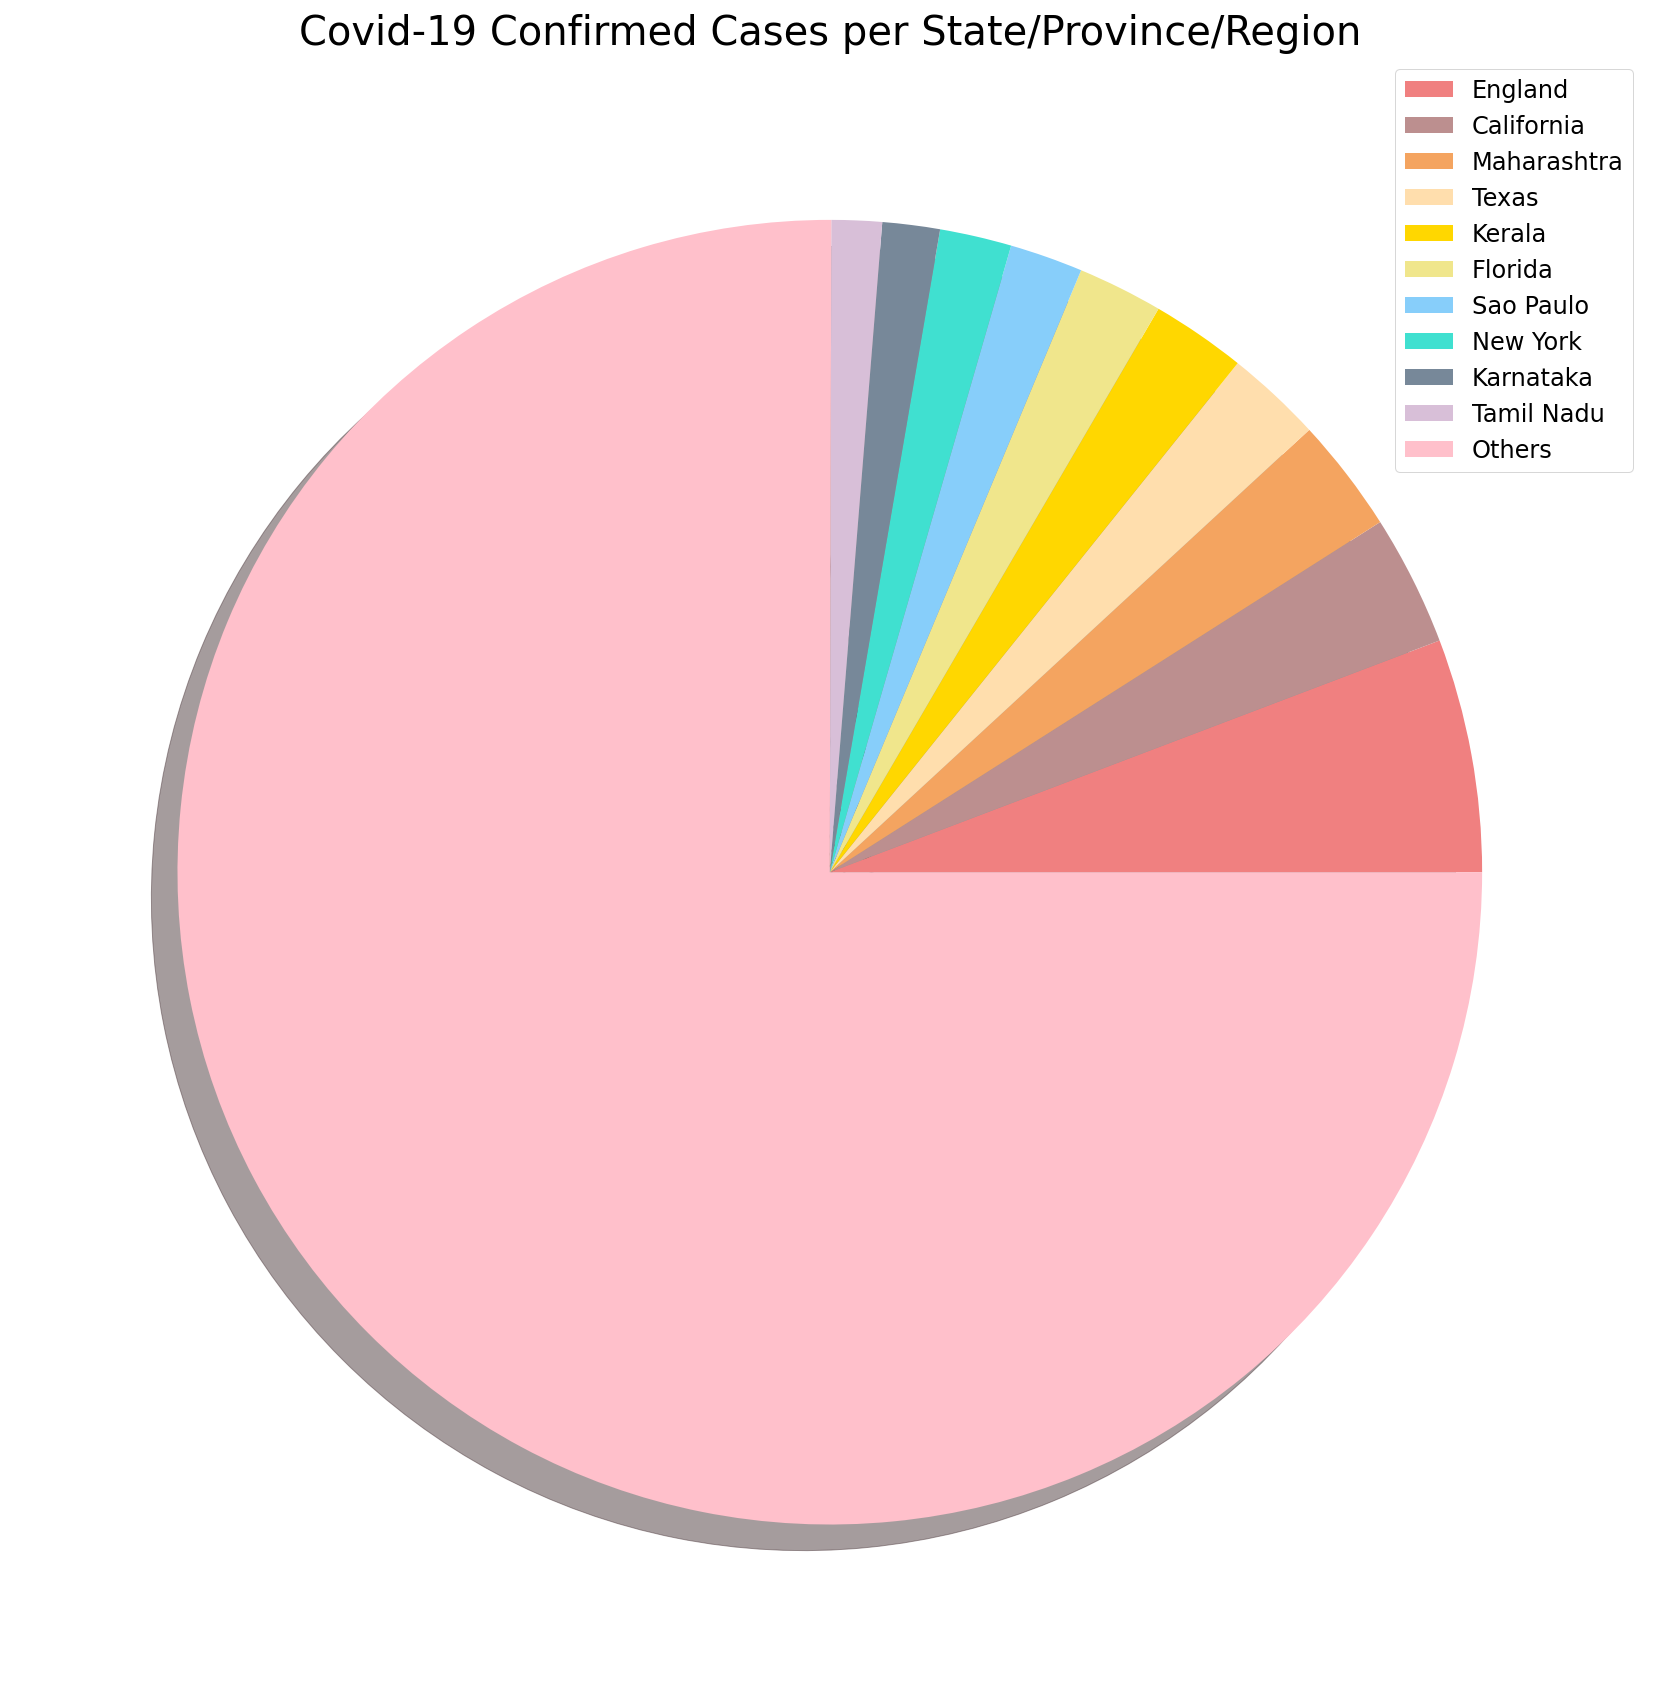

In [60]:
plot_pie_charts(visual_unique_provinces, visual_confirmed_cases2, 'Covid-19 Confirmed Cases per State/Province/Region')

In [61]:
def plot_pie_country_with_regions(country_name, title):
    regions = list(latest_data[latest_data['Country_Region']==country_name]['Province_State'].unique())
    confirmed_cases = []
    no_cases = [] 
    for i in regions:
        cases = latest_data[latest_data['Province_State']==i]['Confirmed'].sum()
        if cases > 0:
            confirmed_cases.append(cases)
        else:
            no_cases.append(i)

    # remove areas with no confirmed cases
    for i in no_cases:
        regions.remove(i)

    # only show the top 5 states
    regions = [k for k, v in sorted(zip(regions, confirmed_cases), key=operator.itemgetter(1), reverse=True)]

    for i in range(len(regions)):
        confirmed_cases[i] = latest_data[latest_data['Province_State']==regions[i]]['Confirmed'].sum()  
    
    # additional province/state will be considered "others"
    
    if(len(regions)>5):
        regions_5 = regions[:5]
        regions_5.append('Others')
        confirmed_cases_5 = confirmed_cases[:5]
        confirmed_cases_5.append(np.sum(confirmed_cases[5:]))
        plot_pie_charts(regions_5,confirmed_cases_5, title)
    else:
        plot_pie_charts(regions,confirmed_cases, title)

In [62]:
pie_chart_countries = ['US', 'Brazil', 'Russia', 'India', 'United Kingdom', 'Italy', 'Germany', 'France', 'Spain', 'Peru', 'Mexico', 'Canada', 
                       'Australia', 'China', 'Chile', 'Colombia', 'Netherlands']

for i in pie_chart_countries:
    plot_pie_country_with_regions(i, 'Covid-19 Confirmed Cases in {}'.format(i))

Output hidden; open in https://colab.research.google.com to view.